# Large scale text analysis with deep learning (3 points)

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

## **Предисловие**
- Ко второй половине 3го курса я как-то совсем устал, что в этот раз отклонюсь от своей традиции писать все комменты на английском))
- Если кратко, то я тут в целом-то сделал всё, что было в условиях, но желание сделать красиво и хорошо переиграло даже мои горящие синим пламенем дедлайны, вот и я решил кучу всего тут переписать.
- Я для своего же удобства и структурности экспериментов переписал всё на Лайтнинг и попытался переиспользовать как можно больше кода, но со сниппетом для обучения происходила странные вещи при оборачивании в функции, поэтому я оставил так, как есть. Считаю, что вышло всё равно достаточно неплохо))
- В рамках своих экспериментов я переписал почти всю логику обработки данных с токенизацией, подачей данных в модель и т.д. Переписал код для векторизации текста, впилив поддержку в целом-то любых сторонних эмбеддингов. Ну и, конечно, постарался относительно детально декомпозировать нейронки, сделав архитектуру как можно более модульной и удобной для экспериментов.
- Считал метрики тоже через torchmetrics, с ним удобнее и более контроллируемо как-то. Метрики контроллировал на comet.ml
- Моя часть лабы (после бойлерплейта) начинается с раздела Real Work, прямо сильно комментировать не стал, но некоторые выводы сделал. Думаю, Вам понравится)))
- Пробовал модели на свёртках, параллельных свёртках, разных видах GRU, комбинациях разных модулей и т.д. Пробовал обучать RandomForest на эмбеддингах и обучать с относительными новыми пулингами, что даже немного помогло нам.

## Imports & stuff

In [4]:
# !apt install unzip gcc build-essential -y

In [2]:
!pip install -U -q nltk typing-extensions gensim pandas comet-ml sklearn seaborn pytorch-lightning torchmetrics wandb rich fasttext

In [3]:
import random
import os

from IPython.display import clear_output
from pprint import pprint

from collections import defaultdict
from functools import partial

import numpy as np
import pandas as pd

import comet_ml
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning import callbacks

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers import CometLogger

import torchmetrics.regression as metrics
from torchmetrics import MetricCollection

from torch.utils.data import Dataset, DataLoader
import gensim.downloader as api

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    r2_score as r2, 
    explained_variance_score as exp_var, 
    mean_squared_error as mse,
    mean_absolute_error as mae
)

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [5]:
os.environ["COMET_API_KEY"] = "*************************"

### About the challenge
For starters, let's download and unpack the data from [here]. 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [7]:
# !wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
!unzip Train_rev1.zip
data = pd.read_csv("Train_rev1.csv", index_col=None)
data.shape

Archive:  Train_rev1.zip
  inflating: Train_rev1.csv          


(244768, 12)

In [8]:
data.head()

Id                                              Title  \
0  12612628                        Engineering Systems Analyst   
1  12612830                            Stress Engineer Glasgow   
2  12612844                   Modelling and simulation analyst   
3  12613049  Engineering Systems Analyst / Mathematical Mod...   
4  12613647         Pioneer, Miser Engineering Systems Analyst   

                                     FullDescription  \
0  Engineering Systems Analyst Dorking Surrey Sal...   
1  Stress Engineer Glasgow Salary **** to **** We...   
2  Mathematical Modeller / Simulation Analyst / O...   
3  Engineering Systems Analyst / Mathematical Mod...   
4  Pioneer, Miser  Engineering Systems Analyst Do...   

                         LocationRaw LocationNormalized ContractType  \
0            Dorking, Surrey, Surrey            Dorking          NaN   
1        Glasgow, Scotland, Scotland            Glasgow          NaN   
2  Hampshire, South East, South East          Hampshire          NaN   
3     Surrey, South East, South East             Surrey          NaN   
4     Surrey, South East, South East             Surrey          NaN   

  ContractTime                       Company          Category  \
0    permanent  Gregory Martin International  Engineering Jobs   
1    permanent  Gregory Martin International  Engineering Jobs   
2    permanent  Gregory Martin International  Engineering Jobs   
3    permanent  Gregory Martin International  Engineering Jobs   
4    permanent  Gregory Martin International  Engineering Jobs   

                                SalaryRaw  SalaryNormalized        SourceName  
0              20000 - 30000/annum 20-30K             25000  cv-library.co.uk  
1              25000 - 35000/annum 25-35K             30000  cv-library.co.uk  
2              20000 - 40000/annum 20-40K             30000  cv-library.co.uk  
3  25000 - 30000/annum 25K-30K negotiable             27500  cv-library.co.uk  
4              20000 - 30000/annum 20-30K             25000  cv-library.co.uk

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

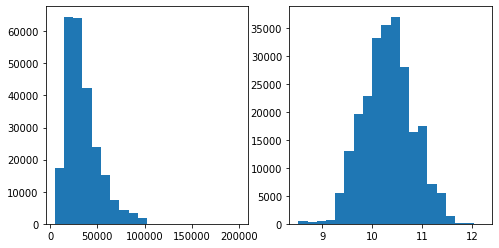

In [9]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [10]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"
data[text_columns] = data[text_columns].fillna('NaN')

data.sample(3)

Id                                              Title  \
30390   68062598                           Business Account Manager   
108709  69622111  Staff Nurse RGN/RMN  Newtown Abbey  Nights  Ne...   
13924   66664026                      Community Fundraising Manager   

                                          FullDescription   LocationRaw  \
30390   Business Account Manager  Plumbing Heating Pro...    South West   
108709  Job Title; Staff Nurse RGN/RMN – NightsLocatio...  Newtownabbey   
13924   This dynamic international development charity...        London   

       LocationNormalized ContractType ContractTime  \
30390   South West London          NaN    permanent   
108709       Newtownabbey    full_time          NaN   
13924              London    full_time    permanent   

                              Company                   Category  \
30390           BMS Sales Specialists                 Sales Jobs   
108709  Regional Recruitment Services  Healthcare & Nursing Jobs   
13924              TPP Not for Profit   Charity & Voluntary Jobs   

                                                SalaryRaw  SalaryNormalized  \
30390   22000 - 25000 per annum + Car,Mobile,Pension,L...             23500   
108709                                         12.00/Hour             23040   
13924                             33300 - 36400 per annum             34850   

               SourceName  Log1pSalary  
30390       totaljobs.com    10.064798  
108709     staffnurse.com    10.045031  
13924   Third Sector Jobs    10.458838

### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [11]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [12]:
import nltk
#TODO YOUR CODE HERE

tokenizer = nltk.tokenize.WordPunctTokenizer()
# YOUR CODE HERE

data[text_columns] = data[text_columns].applymap(lambda x: " ".join(tokenizer.tokenize(x.lower())))

Now we can assume that our text is a space-separated list of tokens:

In [13]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [14]:
from collections import Counter
token_counts = Counter()
# Count how many times does each token occur in both "Title" and "FullDescription" in total
#TODO <YOUR CODE>

for col in text_columns:
    for line in data[col].values:
        token_counts.update(line.split(" "))

In [15]:
  print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


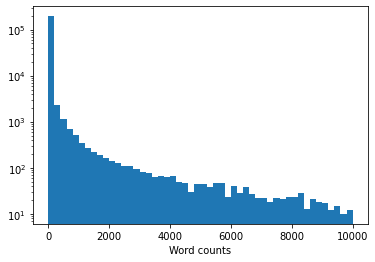

In [16]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [17]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
#TODO <YOUR CODE>
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [18]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [19]:
# TODO <YOUR CODE>
token_to_id = {t: i for i, t in enumerate(tokens)}

In [20]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [21]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [22]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [23]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [24]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=77)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [25]:
def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [26]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[27645, 26986,  1587,   197, 11192,  1700],
         [27280, 13650, 30409,  2844,     1,     1],
         [ 4986,  9083, 18864,     1,     1,     1]]),
 'FullDescription': tensor([[32937, 31100, 33664, 12587,   982, 17753, 11192,  1693,   943,  8110],
         [ 2572, 33996,   982, 13650,   158, 33554,   982,   437, 22021,    82],
         [33996, 33435, 30323, 33554,  3002, 20893, 11312,   158,  7151, 31100]]),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'Log1pSalary': tensor([10.5967,  9.5325, 10.4631])}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [27]:
from functools import partial

import torch
import torch.nn as nn

In [28]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.hid_size = hid_size
        self.n_tokens = n_tokens
        self.n_cat_features = n_cat_features

        self.embedder = nn.Embedding(self.n_tokens, self.hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

    
    def forward(self, batch):
        # YOUR CODE HERE
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [29]:
model = SalaryPredictor()

In [30]:
model = SalaryPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(np.unique(dummy_pred.detach().numpy())) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [31]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [32]:
import tqdm

BATCH_SIZE = 128
EPOCHS = 3
DEVICE = torch.device('cuda')

In [33]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.mean(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.mean(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch)
            
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [34]:
# model = SalaryPredictor().to(DEVICE)
# criterion = nn.MSELoss(reduction='mean')
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# for epoch in range(EPOCHS):
#     print(f"epoch: {epoch}")
#     for i, batch in tqdm.notebook.tqdm(enumerate(
#             iterate_minibatches(
#                     data_train, 
#                     batch_size=BATCH_SIZE, 
#                     device=DEVICE)), 
#                 total=len(data_train) // BATCH_SIZE
#         ):
#         model.train()
#         pred = model(batch)
#         optimizer.zero_grad()
#         loss = criterion(pred, batch[TARGET_COLUMN])
#         loss.backward()
#         optimizer.step()

#         if i % 100 == 99:
#             print('train_loss', loss.item())
#             print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)

# Real Work Section

**Несколько советов по оформлению работы:**
*   В начале ноутбука добавьте небольшое резюме - что Вами было сделано в ноутбуке: что попробовали, какие результаты получили.
*   Все эксперементы оформите с графиками функции потерь и метриками MAE, MSE. Графики постройте на тренировочных, тестовых и валидационных данных. В конце каждого эксперемента выведите лучшие значения.
*   В конце каждого эксперемента напишите свои выводы. Подкрепите их визуализацией и/или метриками.

**Декомпозиция и структура**
- Здесь я сразу переписал всю достаточно старую бойлерплейт логику в этом ноутбуке на Лайтнинг
- Переписал саму модель, совместив её с процессом обучения
- Переписал всё на Dataset и DataLoader и т.д.
- Разбил всё на модули для удобной замены компонентов

### Вся структура манипуляции с данными и моделями в одном месте

In [35]:
class DataCollator:
    def __init__(self, vocab=token_to_id, max_len=None, dropout_prob=0, stage="train"):
        self.stage = stage
        self.max_len = max_len
        
        self.vocab = vocab
        self.dropout_prob = dropout_prob
        
        assert ("UNK" in self.vocab) and ("PAD" in self.vocab)
        
        self.unk_id = self.vocab.get("UNK", 0)
        self.pad_id = self.vocab.get("PAD", 1)
        
    def __call__(self, data):
        """
        Creates a batch with optional word dropout and truncation
        """
        
        batch = defaultdict(list)
        
        for datum in data:
            for feature_name, feature_val in datum.items():
                batch[feature_name].append(feature_val)
        
        batch = self._transform_batch(batch)
        
        return batch
        
    def _transform_batch(self, batch):
        """
        Casts batch arrays to tensors with specified dtype
        """
        
        batch_tensors = dict()
        
        for key, arr in batch.items():
            arr = np.array(arr)
            
            if key in ["FullDescription", "Title"]:
                
                arr = self.vectorize(arr)
                
                if (self.dropout_prob != 0) and (key == "FullDescription") and (self.stage == "train"):
                    arr = apply_word_dropout(arr, 1. - self.dropout_prob)
                    
                batch_tensors[key] = torch.tensor(arr, dtype=torch.int64)
            else:
                batch_tensors[key] = torch.tensor(arr)
                
        return batch_tensors
    
    def vectorize(self, sequences):
        """Convert a list of tokens into a matrix with padding"""
        
        if isinstance(sequences[0], str):
            sequences = list(map(str.split, sequences))

        max_len = min(max(map(len, sequences)), self.max_len or float('inf'))
        matrix = np.full((len(sequences), max_len), np.int32(self.pad_id))
        
        for i, seq in enumerate(sequences):
            row_ix = [self.vocab.get(word, self.unk_id) for word in seq[:max_len]]
            matrix[i, :len(row_ix)] = row_ix

        return matrix

In [36]:
class SalaryDataset(Dataset):
    def __init__(self, data: pd.DataFrame, max_len=None):
        self.data = {
            "Title": data["Title"].values,
            "FullDescription": data["FullDescription"].values,
            "Categorical": categorical_vectorizer.transform(
                data[categorical_columns].apply(dict, axis=1)
            )
        }
        
        if "Log1pSalary" in data.columns:
            self.data["Log1pSalary"] = data["Log1pSalary"].values
        
        self.size = data.shape[0]
        
    def __getitem__(self, index):
        """
        Batch getter
        """
        
        item = {}
        
        for feat, feat_values in self.data.items():
            item[feat] = feat_values[index]
            
        if "Log1pSalary" in self.data:
            item["Log1pSalary"] = self.data["Log1pSalary"][index]
        
        return item
    
    def __len__(self):
        return self.size

In [37]:
class ConvBlock(pl.LightningModule):
    def __init__(
        self,
        hidden_size=8,
        kernel_size=2
    ):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
    
        self.conv = nn.Sequential(
            nn.LazyConv1d(self.hidden_size, self.kernel_size, padding=1),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

    def forward(self, x):
        return self.conv(x).squeeze()

In [38]:
class ParallelConvBlock(pl.LightningModule):
    def __init__(
        self,
        conv_block=ConvBlock,
        hidden_size=8,
        kernel_sizes=[2, 4, 6]
    ):
        super().__init__()
        
        self.conv_block = conv_block
        self.hidden_size = hidden_size
        self.kernel_sizes = kernel_sizes
        
        self.conv_blocks = nn.ModuleList()
        
        for kernel_size in self.kernel_sizes:
            interim_conv = self.conv_block(self.hidden_size, kernel_size)
            self.conv_blocks.append(interim_conv)
            
    def forward(self, x):
        x = torch.cat([conv_block(x) for conv_block in self.conv_blocks], dim=1)
        return x

In [252]:
class SequentialLinearBlock(pl.LightningModule):
    def __init__(
        self,
        hidden_size=8,
        num_blocks=1
    ):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_blocks = num_blocks
        
        self.linear_block_main = nn.Sequential(
            nn.LazyLinear(self.hidden_size),
            nn.ReLU()
        )
        
        self.linear_block_aux = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU()
        )
        
        self.linear_blocks = nn.Sequential(
            *([self.linear_block_aux] * self.num_blocks)
        )
            
    def forward(self, x):
        x = self.linear_block_main(x)
        x = self.linear_blocks(x)
        return x

In [265]:
class SalaryPredictor(pl.LightningModule):
    def __init__(
        self, 
        n_tokens=len(tokens),
        hid_size=8,
        embedder=None,
        text_encoder=ParallelConvBlock(),
        cat_encoder=SequentialLinearBlock(),
        final_encoder=SequentialLinearBlock(),
    ):
        super().__init__()
        
        model_metrics = MetricCollection(
            [
                metrics.MeanSquaredError(),
                metrics.MeanAbsoluteError(),
                metrics.ExplainedVariance()
            ]
        )
        
        self.train_metrics = model_metrics.clone(prefix="train_")
        self.val_metrics = model_metrics.clone(prefix="val_")
        
        self.hid_size = hid_size
        self.n_tokens = n_tokens
        
        if embedder is None:
            self.embedder = nn.Embedding(self.n_tokens, self.hid_size)
        else:
            self.embedder = embedder
        
        self.title_encoder = text_encoder
        self.description_encoder = text_encoder
        self.categorical_encoder = cat_encoder
        
        self.final_predictor = nn.Sequential(
            final_encoder,
            nn.LazyLinear(1)
        )


    def forward(self, batch):
        """
        Extracts features
        """
        
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        
        title_features = self.title_encoder(title_embeddings)
        description_features = self.description_encoder(description_embeddings)
        categorical_features = self.categorical_encoder(batch['Categorical'])
        
#         print("!", title_features.shape)
#         print("!!", description_features.shape)
#         print("!!!", categorical_features.shape)

        features = torch.cat(
            [title_features, description_features, categorical_features], 
            dim=1
        )
        
#         print("Features", features.shape)
        
        return self.final_predictor(features).squeeze()
    
    def training_step(self, batch, batch_idx):
        preds = self(batch)
        target = batch["Log1pSalary"]
        
        loss = F.mse_loss(preds, target)
        metrics = self.train_metrics(preds, target)
        
        self.log("train_loss", loss)
        self.log_dict(metrics)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        preds = self(batch)
        target = batch["Log1pSalary"]
    
        loss = F.mse_loss(preds, target)
        metrics = self.val_metrics(preds, target)
        
        self.log("val_loss", loss, on_step=True)
        self.log_dict(metrics)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
        return optimizer

In [ ]:
class ConvBlockNorm(ConvBlock):
    def __init__(
        self,
        hidden_size=8,
        kernel_size=2
    ):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
    
        self.conv = nn.Sequential(
            nn.LazyConv1d(self.hidden_size, self.kernel_size, padding=1),
            nn.LazyBatchNorm1d(),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

In [ ]:
class ConvBlockNormAvgPool(ConvBlock):
    def __init__(
        self,
        hidden_size=8,
        kernel_size=2
    ):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
    
        self.conv = nn.Sequential(
            nn.LazyConv1d(self.hidden_size, self.kernel_size, padding=1),
            nn.AvgPool1d(2, count_include_pad=True, padding=1),
            nn.LazyBatchNorm1d(),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

In [ ]:
class ConvBlockNormMaxPool(ConvBlock):
    def __init__(
        self,
        hidden_size=8,
        kernel_size=2
    ):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
    
        self.conv = nn.Sequential(
            nn.LazyConv1d(self.hidden_size, self.kernel_size, padding=1),
            nn.MaxPool1d(2, padding=1),
            nn.LazyBatchNorm1d(),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

In [ ]:
class GRUBlockNormMaxPool(pl.LightningModule):
    def __init__(
        self,
        hidden_size=8,
        num_layers=1,
        bidirectional=True
    ):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.max_pool = nn.AdaptiveMaxPool1d(self.hidden_size)
        
        self.gru = nn.GRU(
            input_size=self.hidden_size, 
            hidden_size=self.hidden_size, 
            num_layers=self.num_layers, 
            batch_first=True, 
            bidirectional=self.bidirectional
        )
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.max_pool(x)
        
        out, hn = self.gru(x)  
        
        if self.bidirectional:
            h_1, h_2 = hn[0], hn[1]
            hidden_state = torch.cat([h_1, h_2], dim=1)
        else:
            hidden_state = hn.squeeze(0)
            
        return hidden_state

In [ ]:
class MixSalaryPredictor(SalaryPredictor):
    def __init__(
        self, 
        n_tokens=len(tokens),
        hid_size=8,
        embedder=None,
        title_encoder=ParallelConvBlock(),
        description_encoder=GRUBlockNormMaxPool(),
        cat_encoder=SequentialLinearBlock(),
        final_encoder=SequentialLinearBlock()
    ):
        super().__init__()
    
        self.embedder = embedder
        self.title_encoder = title_encoder
        self.description_encoder = description_encoder

In [ ]:
class ConvBlockNormSoftmax(ConvBlockNorm):
    def __init__(
        self,
        hidden_size=8,
        kernel_size=2
    ):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
    
        self.conv = nn.Sequential(
            nn.LazyConv1d(self.hidden_size, self.kernel_size, padding=1),
            nn.Softmax(dim=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

In [ ]:
class ConvBlockNormAttention(ConvBlockNormSoftmax):
    def __init__(self, hidden_size=8, kernel_size=2):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.LazyConv1d(self.hidden_size, self.kernel_size, padding=1),
            SelfAttentionPooling()
        )

In [ ]:
class SelfAttentionPooling(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.weight = nn.LazyLinear(1)

    def forward(self, batch):
        batch = batch.permute(0, 2, 1)
        weights = self.weight(batch)
        
        att_w = F.softmax(self.weight(batch).squeeze(-1)).unsqueeze(-1)
        embedding = torch.sum(batch * att_w, dim=1)
        
        return embedding

### Инициализируем датасет, collate_fn и dataloader для каждого сета

In [41]:
train_data = SalaryDataset(data_train)
val_data = SalaryDataset(data_val)

train_collator = DataCollator(
    stage="train", 
    dropout_prob=0.2, 
    vocab=token_to_id
)
val_collator = DataCollator(
    stage="val",
    vocab=token_to_id
)

train_dataloader = DataLoader(
    train_data, 
    shuffle=True, 
    batch_size=128,
    num_workers=8,
    collate_fn=train_collator
)

val_dataloader = DataLoader(
    val_data, 
    shuffle=False, 
    batch_size=128,
    num_workers=8,
    collate_fn=val_collator
)

### Создадим шаблонные параметры для обучения

In [270]:
model_callbacks = [
    callbacks.EarlyStopping(monitor="val_ExplainedVariance", min_delta=0.01, patience=5, mode="max", strict=False),
    callbacks.RichModelSummary(1)
]

BaseTrainer = partial(
    pl.Trainer,
    accelerator="gpu", 
    max_epochs=15,
    callbacks=model_callbacks,
    enable_checkpointing=True,
    
)

BaseLogger = partial(
    CometLogger,
    api_key=os.environ.get("COMET_API_KEY"),
    project_name="salary-pred",
)

## Тестирование различных архитектур

### Default Configuration

In [63]:
hidden_size = 8

text_encoder = ParallelConvBlock(
    ConvBlock,
    hidden_size=hidden_size,
    kernel_sizes=[2]
)

cat_encoder = SequentialLinearBlock(
    hidden_size=hidden_size * 2,
    num_blocks=2
)

final_encoder = SequentialLinearBlock(
    hidden_size=hidden_size,
    num_blocks=1
)

In [118]:
# Это тот самый +- бойлерплейт код, который я уже не стал дальше сокращать
# и переносил из эксперимента в эксперимент ))

trainer.logger.experiment.end()
clear_output()

trainer = BaseTrainer(
    logger=BaseLogger(experiment_name="model_hidden_8")
)

model = SalaryPredictor(
    hid_size=hidden_size,
    text_encoder=text_encoder,
    cat_encoder=cat_encoder,
    final_encoder=final_encoder
)

trainer.fit(
    model,
    train_dataloader,
    val_dataloader
)

trainer.logger.experiment.end()
clear_output()

final_metrics = trainer.validate(model=model, dataloaders=val_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /workspace/salary-pred/fc8ef7baff994744b8d8a71444d2de0d/checkpoints/epoch=13-step=24108.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /workspace/salary-pred/fc8ef7baff994744b8d8a71444d2de0d/checkpoints/epoch=13-step=24108.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   val_ExplainedVariance   │    0.6654520630836487     │
│   val_MeanAbsoluteError   │    1.4630193710327148     │
│   val_MeanSquaredError    │    2.2208375930786133     │
│      val_loss_epoch       │    2.2208375930786133     │
└───────────────────────────┴───────────────────────────┘

#### Metrics

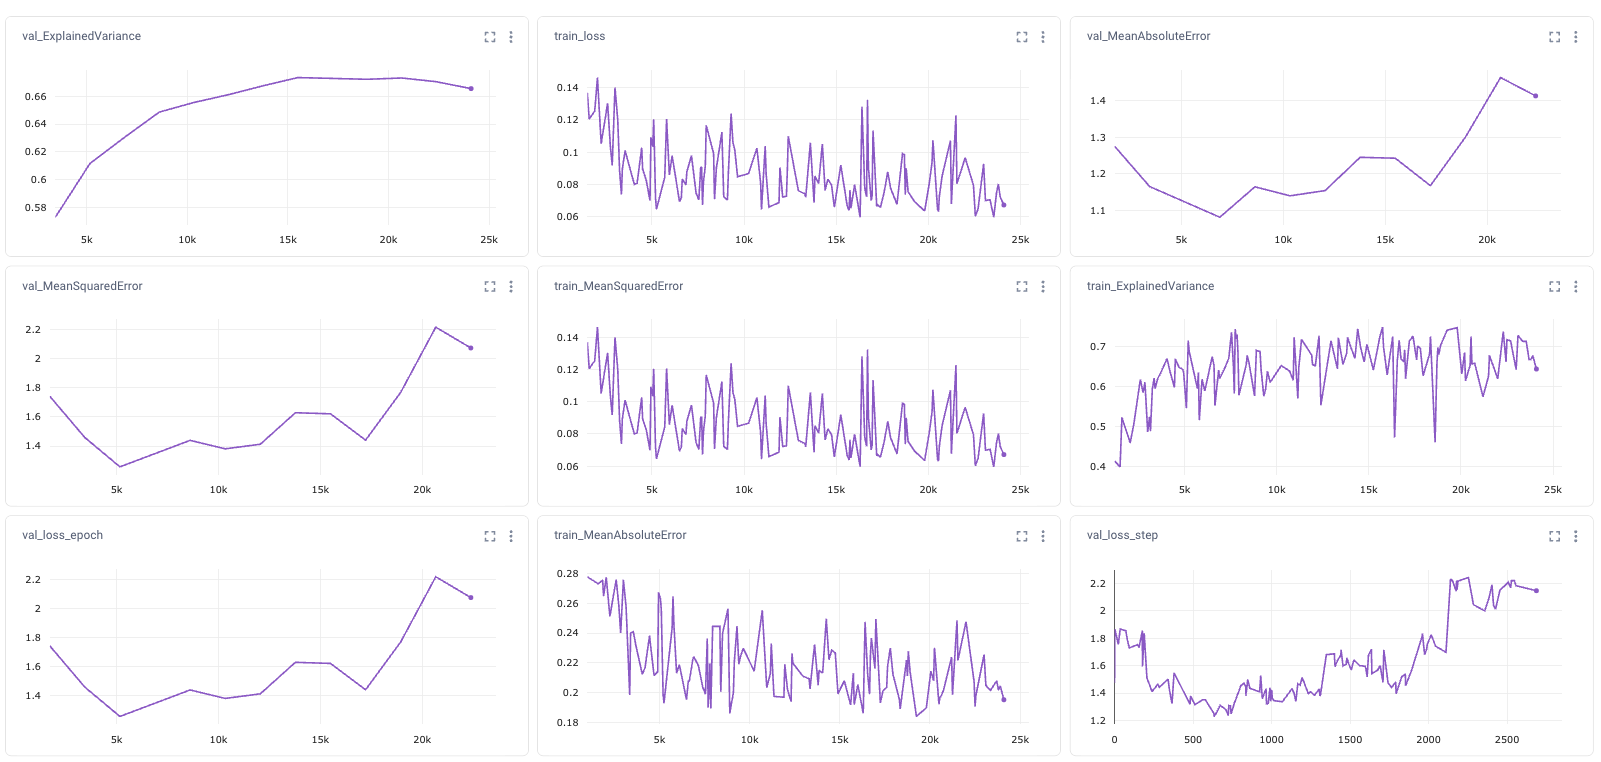

- Здесь в целом-то видно, что ошибка достаточно большая на валидации, но низкая на трейне
- Модель очевидно оверфитится, но я для всех моделей снимаю ещё и Explained Variance (~= R^2)
- А здесь R^2 относительно неплох

**1. Развейте СNN архитектуру (2 балла)**

Добавьте в пайплайн

*   Batch Norm (nn.BatchNorm), LayerNorm...
*   Параллельные сверточные слои. Идея в том, чтобы применить несколько nn.Conv1d к одному и тому же эмбеддингу и после этого сконкатенировать выходные каналы
*   Больше слоев...
*   Добавьте раннюю остановку

На каких примерах модели ведут себя максимально различно/похоже? Предположите с чем это может быть связано.

Как модель ведет себя в зависимости от количества обучаемых параметров?

### Default Configuration + BatchNorm

In [133]:
text_encoder = ParallelConvBlock(
    ConvBlockNorm,
    hidden_size=hidden_size,
    kernel_sizes=[2]
)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [137]:
trainer.logger.experiment.end()
clear_output()

trainer = BaseTrainer(
    logger=BaseLogger(experiment_name="model_hidden_8_batchnorm")
)

model = SalaryPredictor(
    hid_size=hidden_size,
    text_encoder=text_encoder,
    cat_encoder=cat_encoder,
    final_encoder=final_encoder
)

trainer.fit(
    model,
    train_dataloader,
    val_dataloader
)

trainer.logger.experiment.end()
clear_output()

final_metrics = trainer.validate(model=model, dataloaders=val_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /workspace/salary-pred/30550a2d80314140a4f9737266ccf425/checkpoints/epoch=14-step=25830.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /workspace/salary-pred/30550a2d80314140a4f9737266ccf425/checkpoints/epoch=14-step=25830.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   val_ExplainedVariance   │    0.6882983446121216     │
│   val_MeanAbsoluteError   │    0.4412800669670105     │
│   val_MeanSquaredError    │    0.25294703245162964    │
│      val_loss_epoch       │    0.25294703245162964    │
└───────────────────────────┴───────────────────────────┘

#### Metrics

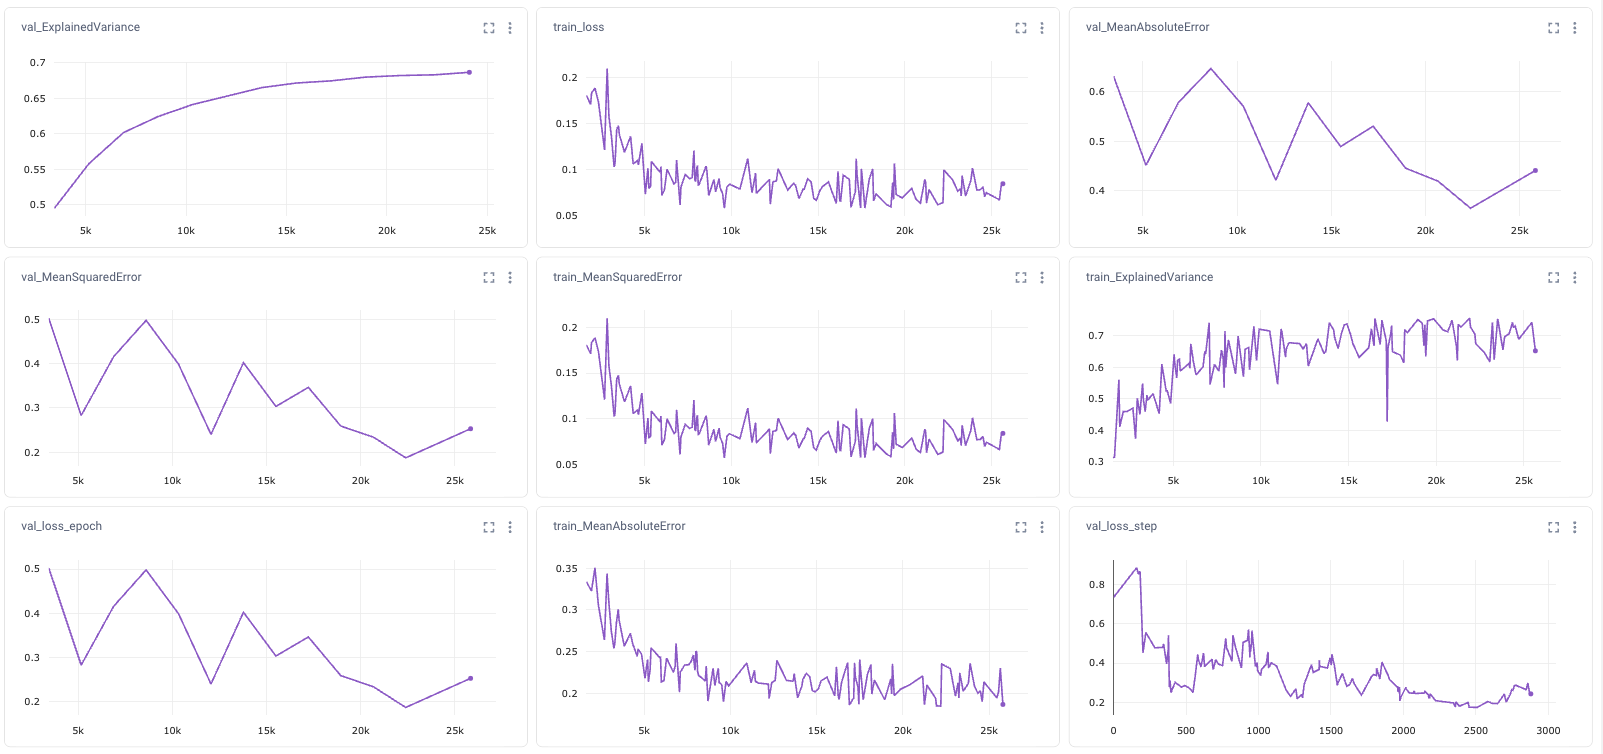

- Видно, что добавление нормализации значительно улучшает результат и модель начинает лучше генерализоваться

### Default Configuration + BatchNorm + ParallelConvBlock (3 blocks with ks=[2, 4, 6])

In [170]:
text_encoder = ParallelConvBlock(
    ConvBlockNorm,
    hidden_size=hidden_size,
    kernel_sizes=[2, 3, 4]
)

final_encoder = SequentialLinearBlock(
    hidden_size=hidden_size,
    num_blocks=1
)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [179]:
trainer.logger.experiment.end()
clear_output()

trainer = BaseTrainer(
    logger=BaseLogger(experiment_name="model_hidden_8_bn_parallel_conv")
)

model = SalaryPredictor(
    hid_size=hidden_size,
    text_encoder=text_encoder,
    cat_encoder=cat_encoder,
    final_encoder=final_encoder
)

trainer.fit(
    model,
    train_dataloader,
    val_dataloader
)

trainer.logger.experiment.end()
clear_output()

final_metrics = trainer.validate(model=model, dataloaders=val_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /workspace/salary-pred/07eb7b1e4140428bb949b58567212143/checkpoints/epoch=14-step=25830.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /workspace/salary-pred/07eb7b1e4140428bb949b58567212143/checkpoints/epoch=14-step=25830.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   val_ExplainedVariance   │    0.7306181192398071     │
│   val_MeanAbsoluteError   │    0.2071358859539032     │
│   val_MeanSquaredError    │    0.07609674334526062    │
│      val_loss_epoch       │    0.07609674334526062    │
└───────────────────────────┴───────────────────────────┘

#### Metrics

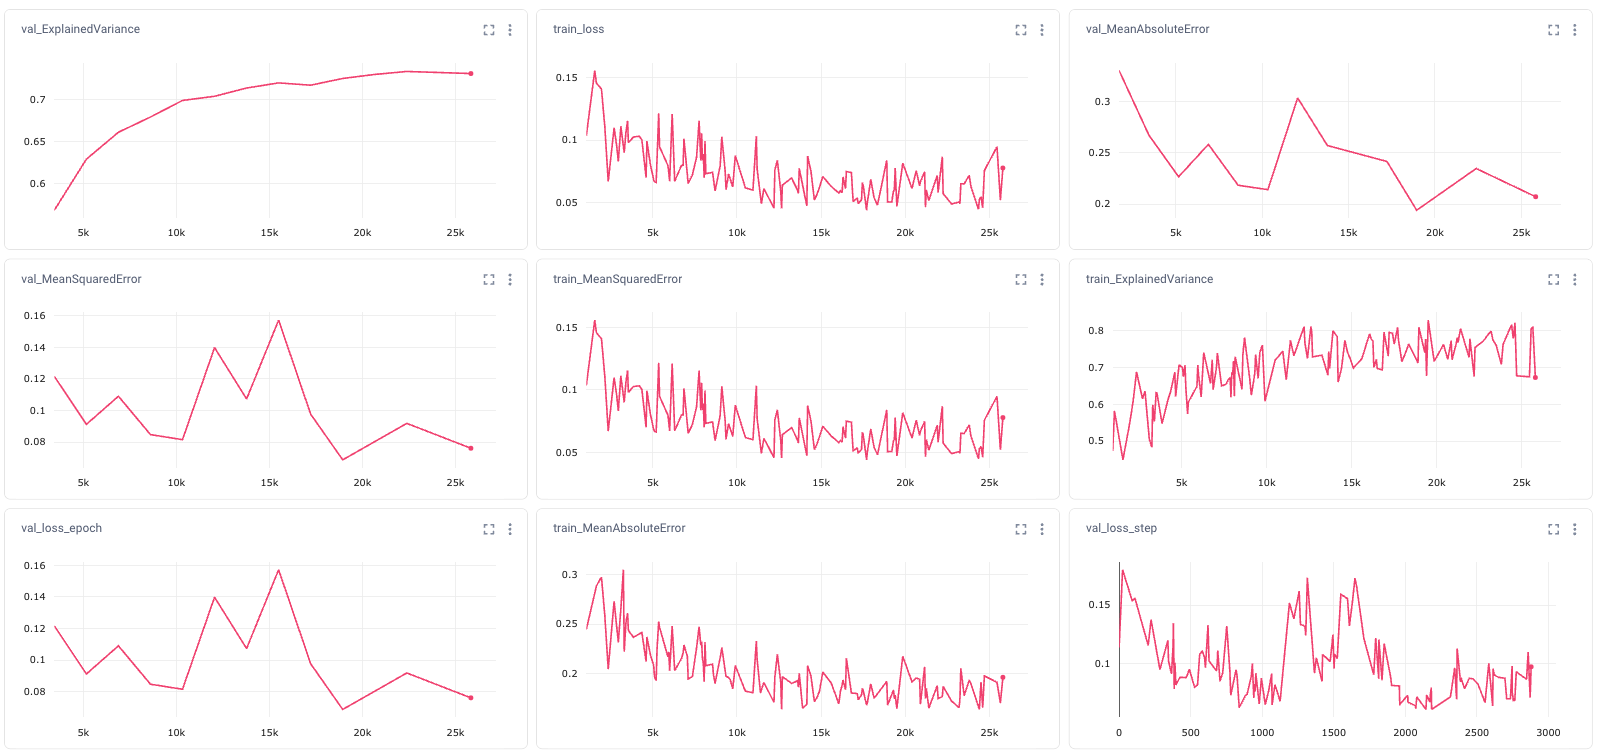

- Добавление параллельных сверток с разными размерами ядер достаточно сильно бустит производительность

### Default Configuration + BatchNorm + ParallelConvBlock (3 blocks with ks=[2, 4, 6]) + stack more layers

In [188]:
text_encoder = ParallelConvBlock(
    ConvBlockNorm,
    hidden_size=hidden_size,
    kernel_sizes=[2, 3, 4]
)

final_encoder = SequentialLinearBlock(
    hidden_size=hidden_size,
    num_blocks=3
)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [191]:
trainer.logger.experiment.end()
clear_output()

trainer = BaseTrainer(
    logger=BaseLogger(experiment_name="model_hidden_8_bn_parallel_conv_stack")
)

model = SalaryPredictor(
    hid_size=hidden_size,
    text_encoder=text_encoder,
    cat_encoder=cat_encoder,
    final_encoder=final_encoder
)

trainer.fit(
    model,
    train_dataloader,
    val_dataloader
)

trainer.logger.experiment.end()
clear_output()

final_metrics = trainer.validate(model=model, dataloaders=val_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /workspace/salary-pred/0b8099a069844a5fb76b2ab3c338f7b7/checkpoints/epoch=14-step=25830.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /workspace/salary-pred/0b8099a069844a5fb76b2ab3c338f7b7/checkpoints/epoch=14-step=25830.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   val_ExplainedVariance   │    0.7243233919143677     │
│   val_MeanAbsoluteError   │     0.580298662185669     │
│   val_MeanSquaredError    │     0.39505535364151      │
│      val_loss_epoch       │     0.39505535364151      │
└───────────────────────────┴───────────────────────────┘

#### Metrics

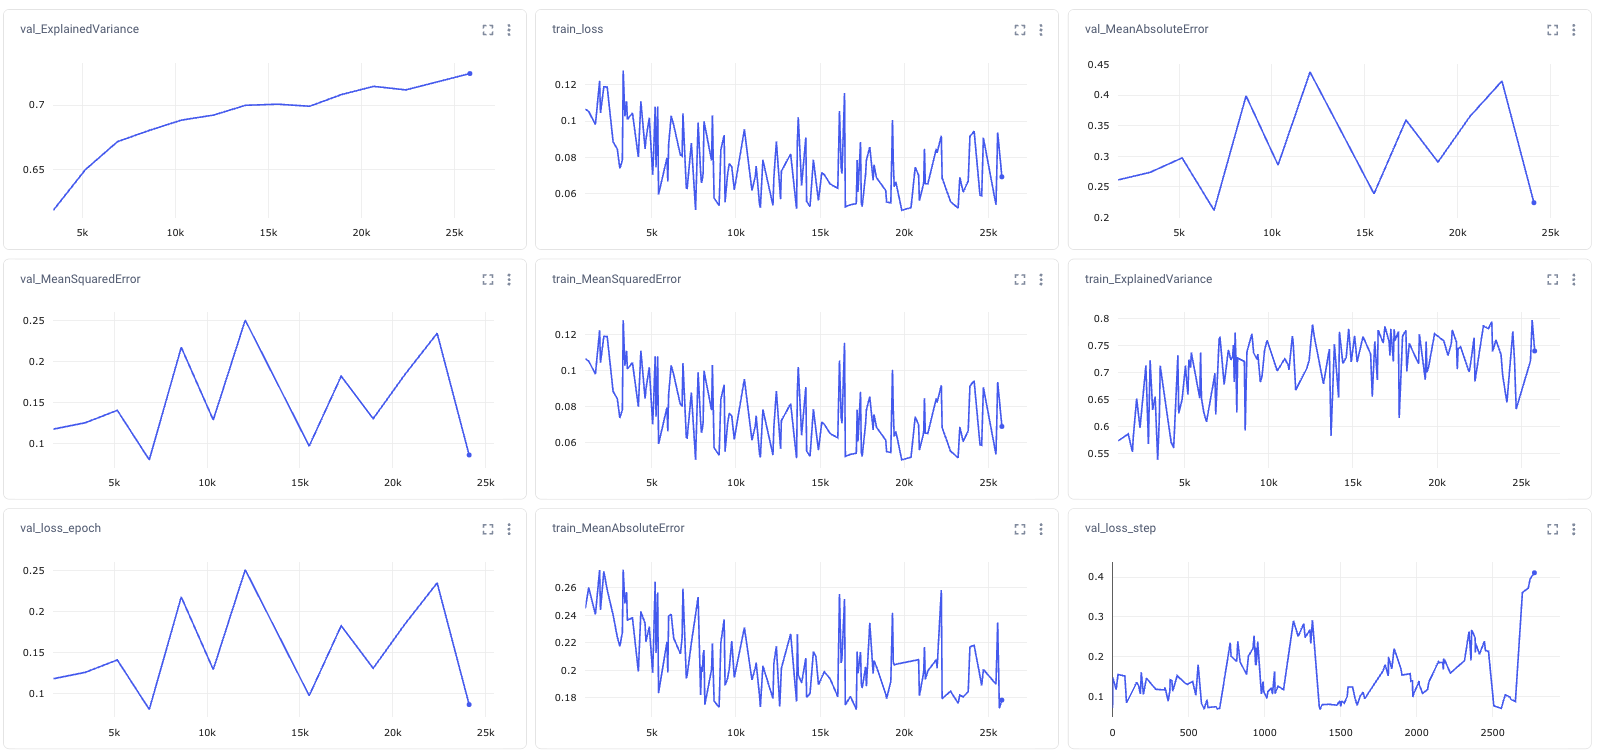

- Добавление бОльшего количество моделей в целом только усложняет модель без прироста к производительности
- Модель начинает только чуть больше оверфититься

**2. Pooling слои стандартные (1 балла)**

*   Опишите своими словами как работает Pooling слой.
*   Взять максимум по временной компоненте (незавимисо для каждой фичи)
*   Взять среднее по временной компоненте (исключая PAD символы)

Применять можно к любой архитектуре (CNN/RNN)

- Вообще, пулинги нужны для снижения размерности фичер мап, что влечёт за собой и снижение количества обучаемых параметров (и нам становится быстрее и проще всё обучать)

In [200]:
text_encoder = ParallelConvBlock(
    ConvBlockNormAvgPool,
    hidden_size=hidden_size,
    kernel_sizes=[2, 3, 4]
)

In [201]:
trainer.logger.experiment.end()
clear_output()

trainer = BaseTrainer(
    logger=BaseLogger(experiment_name="model_hidden_8_bn_parallel_conv_stack_avg")
)

model = SalaryPredictor(
    hid_size=hidden_size,
    text_encoder=text_encoder,
    cat_encoder=cat_encoder,
    final_encoder=final_encoder
)

trainer.fit(
    model,
    train_dataloader,
    val_dataloader
)

trainer.logger.experiment.end()
clear_output()

final_metrics = trainer.validate(model=model, dataloaders=val_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /workspace/salary-pred/cfc6ab3b0fe2466fadc828ac38c17417/checkpoints/epoch=14-step=25830.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /workspace/salary-pred/cfc6ab3b0fe2466fadc828ac38c17417/checkpoints/epoch=14-step=25830.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   val_ExplainedVariance   │    0.7357418537139893     │
│   val_MeanAbsoluteError   │    0.4413811266422272     │
│   val_MeanSquaredError    │    0.2464383840560913     │
│      val_loss_epoch       │    0.2464383840560913     │
└───────────────────────────┴───────────────────────────┘

#### Metrics

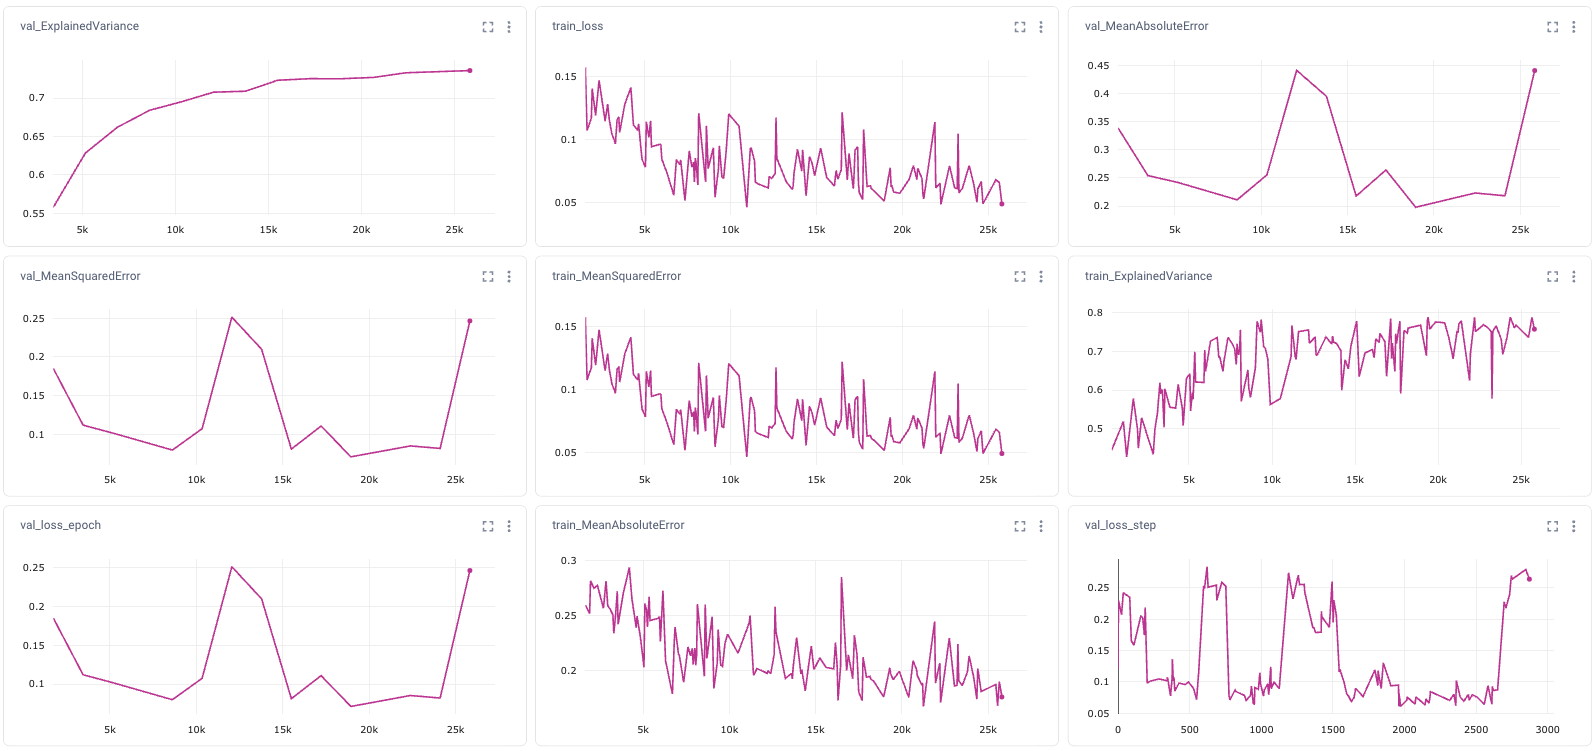

In [204]:
text_encoder = ParallelConvBlock(
    ConvBlockNormMaxPool,
    hidden_size=hidden_size,
    kernel_sizes=[2, 3, 4]
)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [207]:
trainer.logger.experiment.end()
clear_output()

trainer = BaseTrainer(
    logger=BaseLogger(experiment_name="model_hidden_8_bn_parallel_conv_stack_max")
)

model = SalaryPredictor(
    hid_size=hidden_size,
    text_encoder=text_encoder,
    cat_encoder=cat_encoder,
    final_encoder=final_encoder
)

trainer.fit(
    model,
    train_dataloader,
    val_dataloader
)

trainer.logger.experiment.end()
clear_output()

final_metrics = trainer.validate(model=model, dataloaders=val_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /workspace/salary-pred/6d8633a3110f41488474795469f3d411/checkpoints/epoch=14-step=25830.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /workspace/salary-pred/6d8633a3110f41488474795469f3d411/checkpoints/epoch=14-step=25830.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   val_ExplainedVariance   │    0.7382057905197144     │
│   val_MeanAbsoluteError   │    0.35606372356414795    │
│   val_MeanSquaredError    │    0.17399278283119202    │
│      val_loss_epoch       │    0.17399278283119202    │
└───────────────────────────┴───────────────────────────┘

#### Metrics

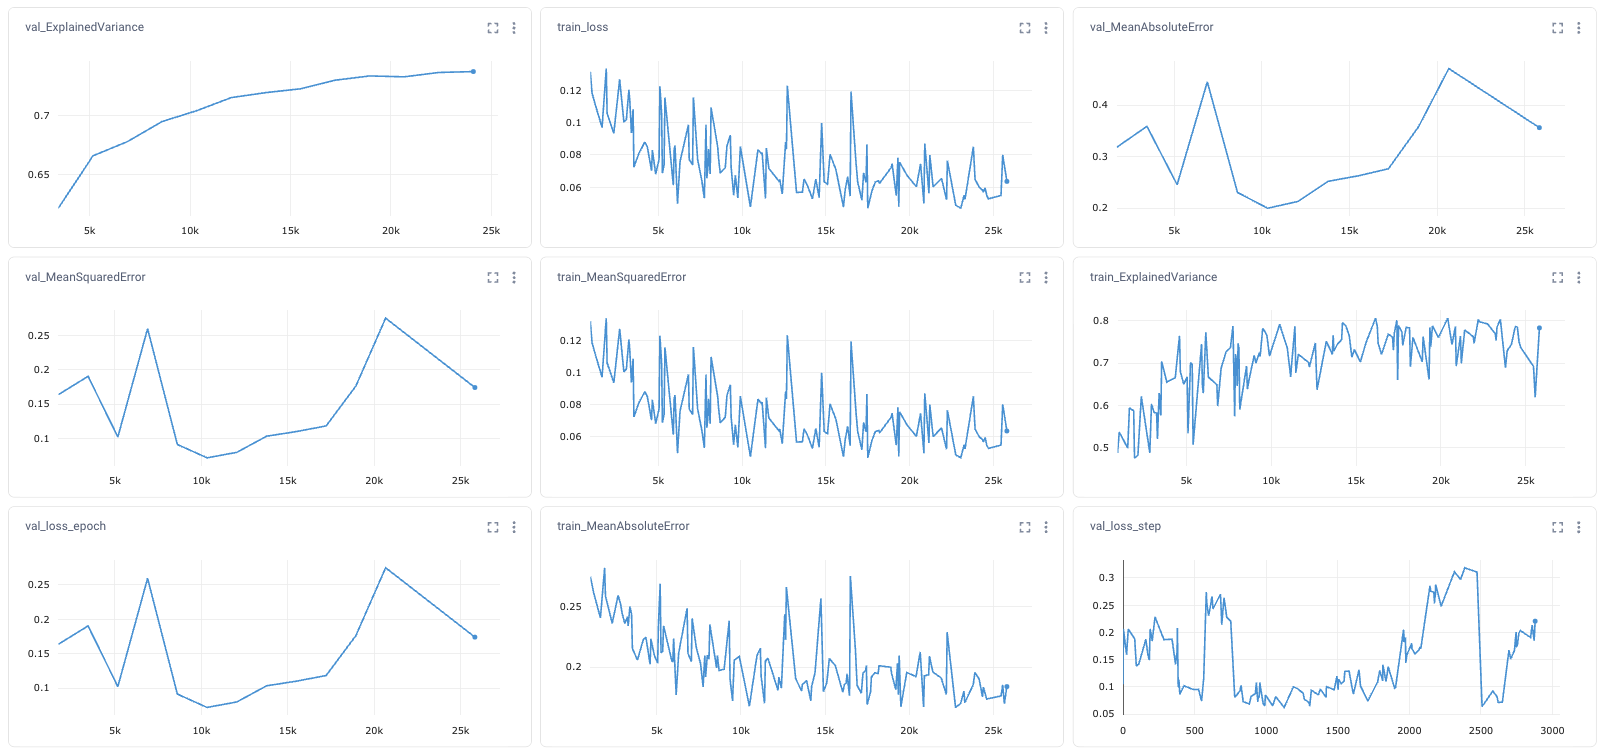

- Видим, что оба вида пулингов показывают сопоставимые результаты на R^2, но MSE и MAE у моделей с ними меньше
- Кроме того, Max Pooling позволяет добиться более низкой ошибки по сравнению с Avg Pooling

**3. Используйте предобученные эмбеддинги (2 балла)**

*   Загрузите предобученные эмбеддинги с помощью gensim.downloader.load
*   Используйте метод [from_pretrained](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) слоя torch.nn.Embedding для инициализации эмбеддингов с помощью предобученных весов. Можете попбровать несколько типов предобученных эмбеддингов.
*   Проведите эксперементы с обучаемыми/замороженными весами эмбеддингов.
Используйте одни и те же эмбеддинги для Title и FullDescription.

Сравните результаты:
1.   Эмбеддингов, инициализируемых случайно из $$\mathcal{N}(0,1)$$ (по умолчанию у слоя torch.nn.Embedding)
2.   Предобученных эмбеддингов с замороженными весами
3.   Предобученных эмбеддингов с обучаемыми весами

Что изменяется в поведении модели? Какой эксперимент дал лучший результат?

- В этот раз будем использовать небольшие предобученные GloVe эмбеддинги
- Используем мой переписанный векторизатор, загрузив новые специальные токены в словарик
- Приведём эмбеддинги в формат Торча и передадим в модель

In [56]:
glove_embeddings = api.load('glove-wiki-gigaword-50')
glove_embeddings.vector_size

[=================---------------------------------] 35.5% 23.4/66.0MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================================----] 93.7% 61.8/66.0MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50

In [57]:
unk_embedding = np.random.normal(size=(50,))
pad_embedding = np.random.normal(size=(50,))

unk_pad_embeddings = np.stack([unk_embedding, pad_embedding])

print(unk_pad_embeddings.shape)

(2, 50)


In [58]:
glove_embeddings.add_vectors(
    keys=["UNK", "PAD"], 
    weights=unk_pad_embeddings
)

In [59]:
glove_vocab = glove_embeddings.key_to_index
print(len(glove_vocab))

assert "UNK" in glove_vocab and "PAD" in glove_vocab

400002


In [60]:
glove_embeddings = torch.tensor(glove_embeddings.vectors, dtype=torch.float32)

glove_embeddings = nn.Embedding.from_pretrained(glove_embeddings)
glove_embeddings.requires_grad = True

In [61]:
train_collator = DataCollator(
    stage="train", 
    dropout_prob=0.2, 
    vocab=glove_vocab
)
val_collator = DataCollator(
    stage="val",
    vocab=glove_vocab
)

In [122]:
text_encoder = ParallelConvBlock(
    ConvBlockNorm,
    hidden_size=hidden_size,
    kernel_sizes=[2, 3, 4]
)

final_encoder = SequentialLinearBlock(
    hidden_size=hidden_size,
    num_blocks=1
)

In [150]:
trainer.logger.experiment.end()
clear_output()

trainer = BaseTrainer(
    logger=BaseLogger(experiment_name="model_hidden_8_bn_parallel_conv_pretrained_freeze")
)

model = SalaryPredictor(
    embedder=glove_embeddings,
    hid_size=hidden_size,
    text_encoder=text_encoder,
    cat_encoder=cat_encoder,
    final_encoder=final_encoder
)

trainer.fit(
    model,
    train_dataloader,
    val_dataloader
)

trainer.logger.experiment.end()
clear_output()

final_metrics = trainer.validate(model=model, dataloaders=val_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /workspace/salary-pred/ff6b616f973f460f9738080abc1247da/checkpoints/epoch=14-step=25830.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /workspace/salary-pred/ff6b616f973f460f9738080abc1247da/checkpoints/epoch=14-step=25830.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   val_ExplainedVariance   │    0.6094032526016235     │
│   val_MeanAbsoluteError   │    0.9538390040397644     │
│   val_MeanSquaredError    │    0.9996025562286377     │
│      val_loss_epoch       │    0.9996025562286377     │
└───────────────────────────┴───────────────────────────┘

#### Metrics

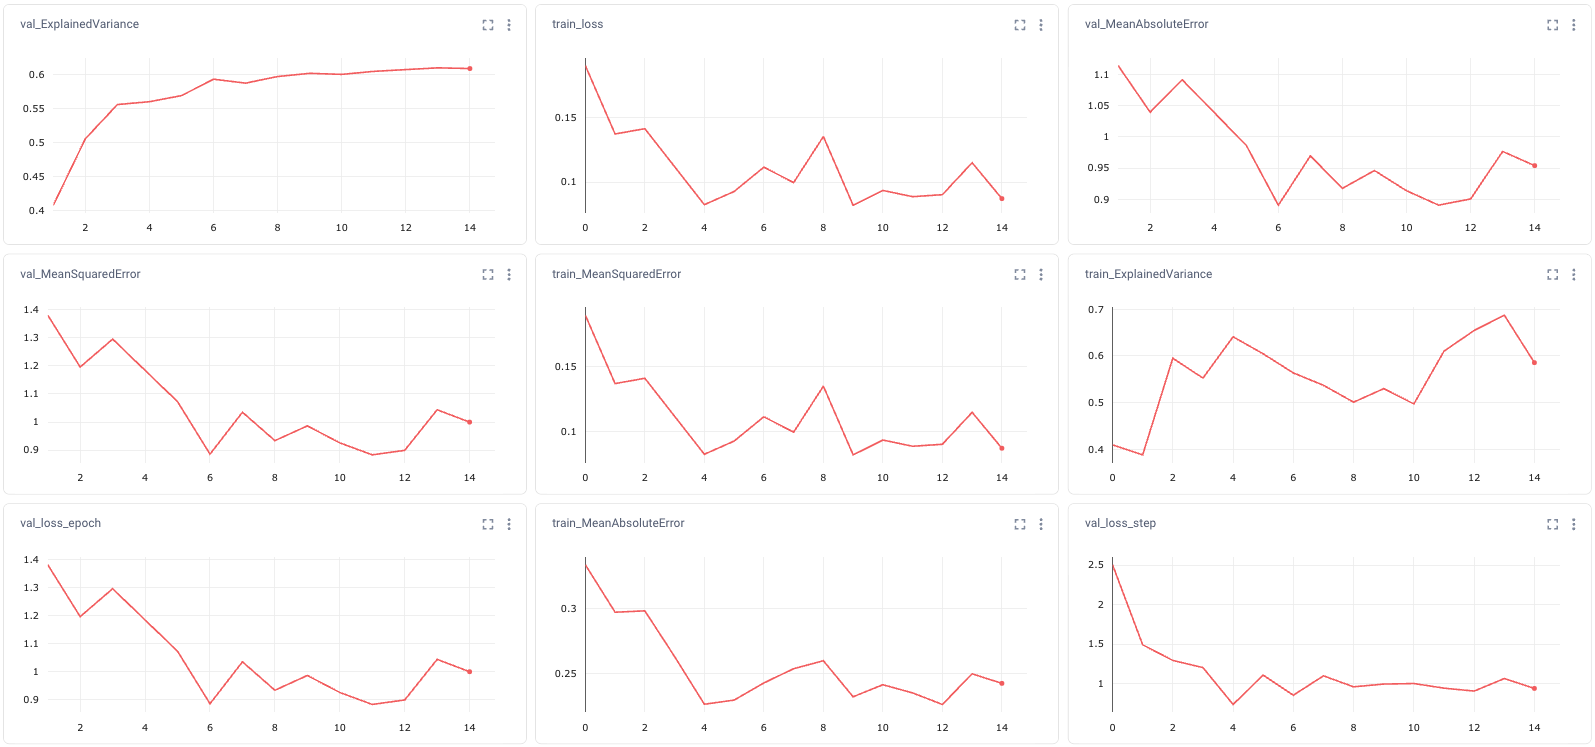

In [153]:
glove_embeddings.requires_grad = True
glove_embeddings.weight.requires_grad = True

In [154]:
trainer.logger.experiment.end()
clear_output()

trainer = BaseTrainer(
    logger=BaseLogger(experiment_name="model_hidden_8_bn_parallel_conv_pretrained_unfreeze")
)

model = SalaryPredictor(
    embedder=glove_embeddings,
    hid_size=hidden_size,
    text_encoder=text_encoder,
    cat_encoder=cat_encoder,
    final_encoder=final_encoder
)

trainer.fit(
    model,
    train_dataloader,
    val_dataloader
)

trainer.logger.experiment.end()
clear_output()

final_metrics = trainer.validate(model=model, dataloaders=val_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /workspace/salary-pred/ff6b616f973f460f9738080abc1247da/checkpoints/epoch=13-step=24108.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /workspace/salary-pred/ff6b616f973f460f9738080abc1247da/checkpoints/epoch=13-step=24108.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   val_ExplainedVariance   │    0.7595325708389282     │
│   val_MeanAbsoluteError   │    0.8677002787590027     │
│   val_MeanSquaredError    │    0.8077777624130249     │
│      val_loss_epoch       │    0.8077777624130249     │
└───────────────────────────┴───────────────────────────┘

#### Metrics

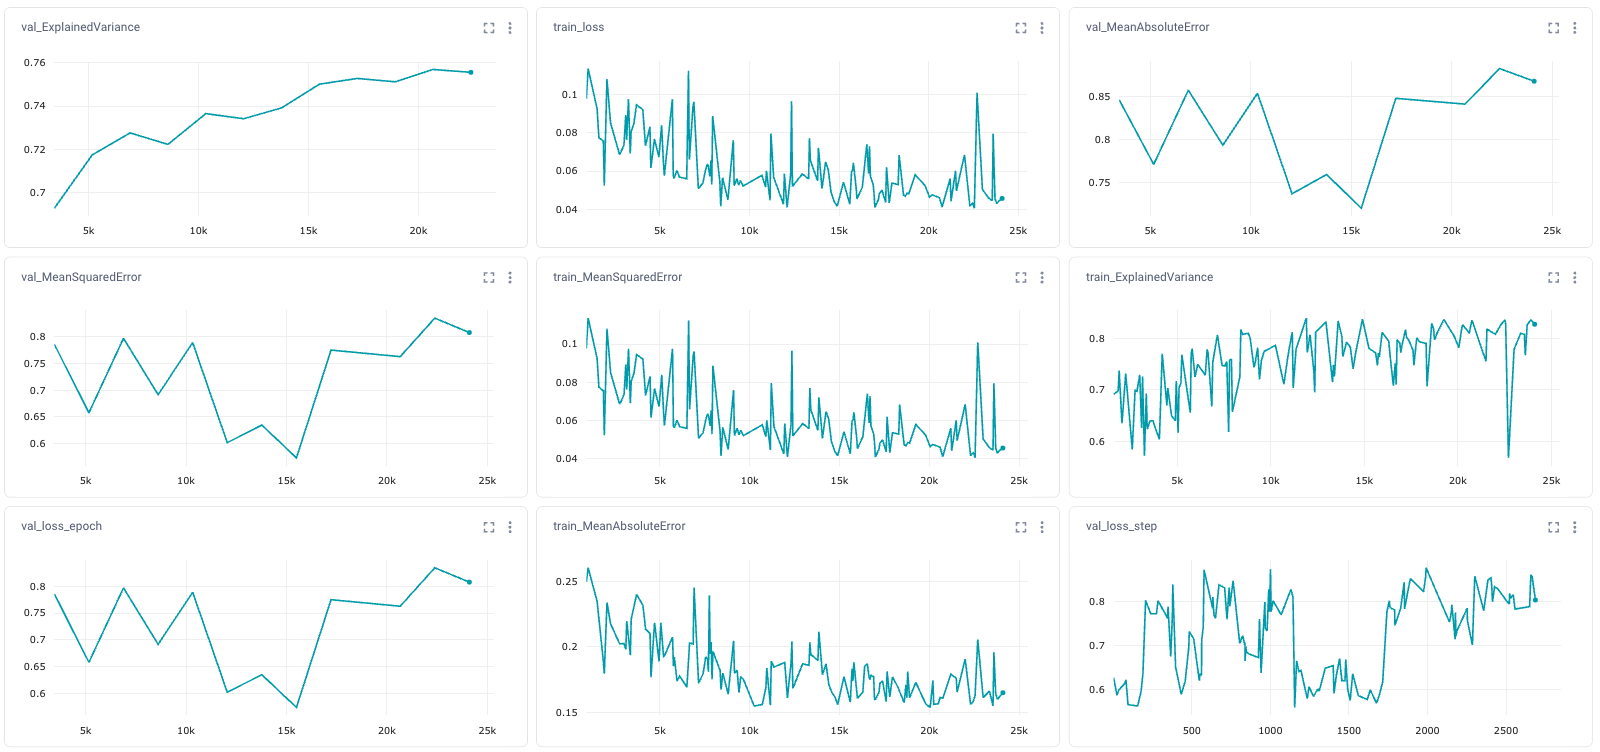

- Видим, что замороженные эмбеддинги только ухудшают результат (оно и понятно)
- Но при этом замечаем, что обучаемые эмбеддинги дают буст к производительности с самого старта

**4. Замените сверточные слои на рекуррентные (3 балла)**

* Замените сверточне слоим рекуррентными LSTM/GRU.
* Проведите эксперимент с однонаправленной и двунаправленной рекуррентной нейросетью
* Попробуйте найти удачный микс рекуррентных и сверточных слоев. Попробуйте разные миксы для Title и FullDescription

In [58]:
hidden_size = 25

text_encoder = GRUBlockNormMaxPool(
    hidden_size=hidden_size,
    num_layers=1,
    bidirectional=False
)

final_encoder = SequentialLinearBlock(
    hidden_size=hidden_size,
    num_blocks=1
)

In [315]:
trainer.logger.experiment.end()
clear_output()

trainer = BaseTrainer(
    logger=BaseLogger(experiment_name="model_hidden_8_bn_gru_pretrained_unfreeze")
)

model = SalaryPredictor(
    embedder=glove_embeddings,
    hid_size=hidden_size,
    text_encoder=text_encoder,
    cat_encoder=cat_encoder,
    final_encoder=final_encoder
)

trainer.fit(
    model,
    train_dataloader,
    val_dataloader
)

trainer.logger.experiment.end()
clear_output()

final_metrics = trainer.validate(model=model, dataloaders=val_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /workspace/salary-pred/39982f55c5c642028173e9dd4069c32e/checkpoints/epoch=0-step=1722.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /workspace/salary-pred/39982f55c5c642028173e9dd4069c32e/checkpoints/epoch=0-step=1722.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   val_ExplainedVariance   │    0.5885986685752869     │
│   val_MeanAbsoluteError   │    0.24465405941009521    │
│   val_MeanSquaredError    │     0.104556143283844     │
│      val_loss_epoch       │     0.104556143283844     │
└───────────────────────────┴───────────────────────────┘

#### Metrics

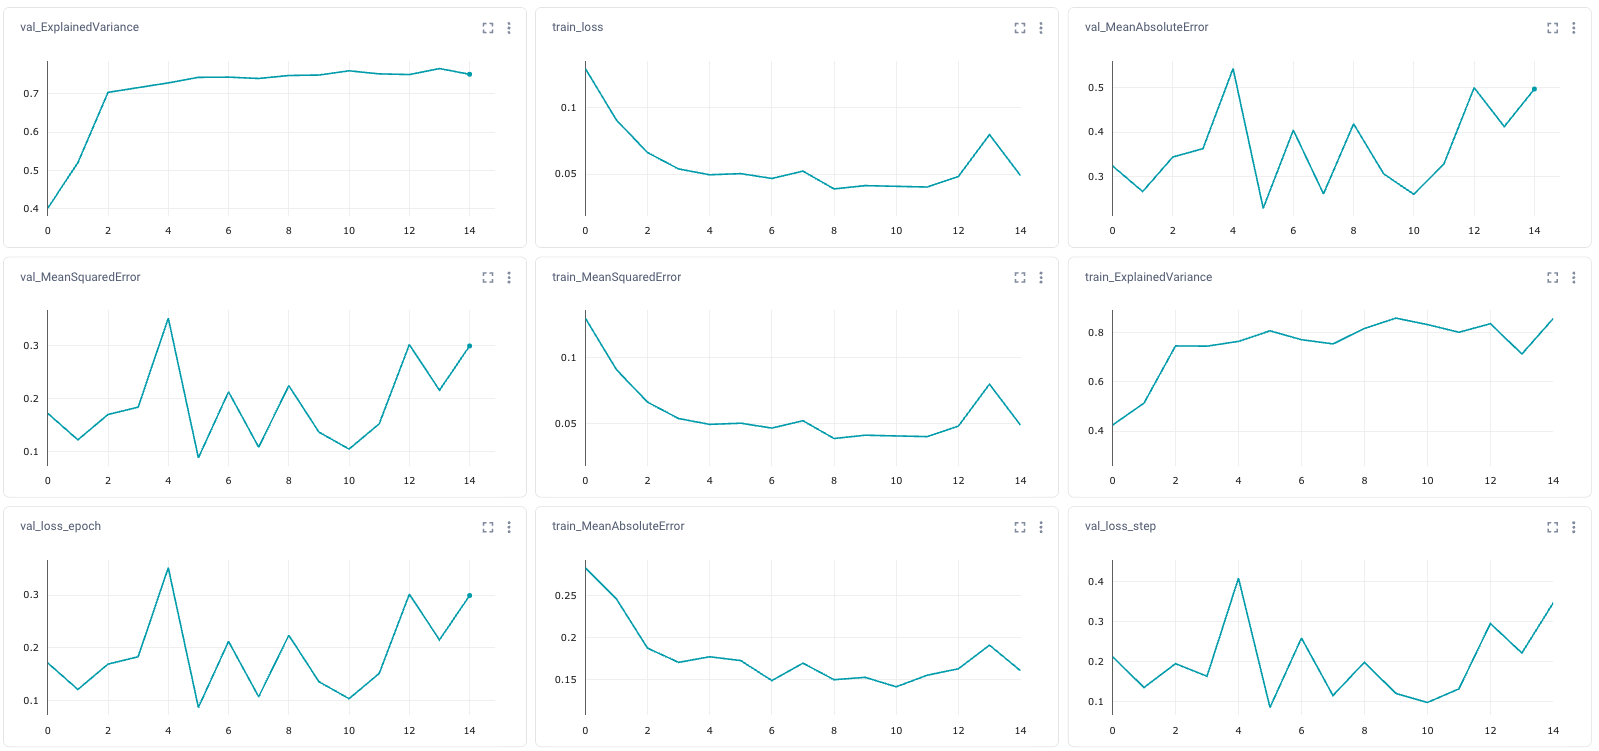

- Рассмотрим одностороний GRU
- У меня здесь почему-то вывелись метрики не с лучшей модели, но по графикам мы видим качество работы модели
- И видим, что оно достаточно неплохое, хотя ошибка на валидации и прыгает вверз-вниз (мы могли быть уменьшить lr, например)

In [285]:
text_encoder = GRUBlockNormMaxPool(
    hidden_size=hidden_size,
    num_layers=1,
    bidirectional=True
)

In [288]:
trainer.logger.experiment.end()
clear_output()

trainer = BaseTrainer(
    logger=BaseLogger(experiment_name="model_hidden_8_bn_bigru_pretrained_unfreeze")
)

model = SalaryPredictor(
    embedder=glove_embeddings,
    hid_size=hidden_size,
    text_encoder=text_encoder,
    cat_encoder=cat_encoder,
    final_encoder=final_encoder
)

trainer.fit(
    model,
    train_dataloader,
    val_dataloader
)

trainer.logger.experiment.end()
clear_output()

final_metrics = trainer.validate(model=model, dataloaders=val_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /workspace/salary-pred/39982f55c5c642028173e9dd4069c32e/checkpoints/epoch=12-step=22386.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /workspace/salary-pred/39982f55c5c642028173e9dd4069c32e/checkpoints/epoch=12-step=22386.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   val_ExplainedVariance   │    0.7540810704231262     │
│   val_MeanAbsoluteError   │    0.2528299391269684     │
│   val_MeanSquaredError    │    0.10125822573900223    │
│      val_loss_epoch       │    0.10125822573900223    │
└───────────────────────────┴───────────────────────────┘

#### Metrics

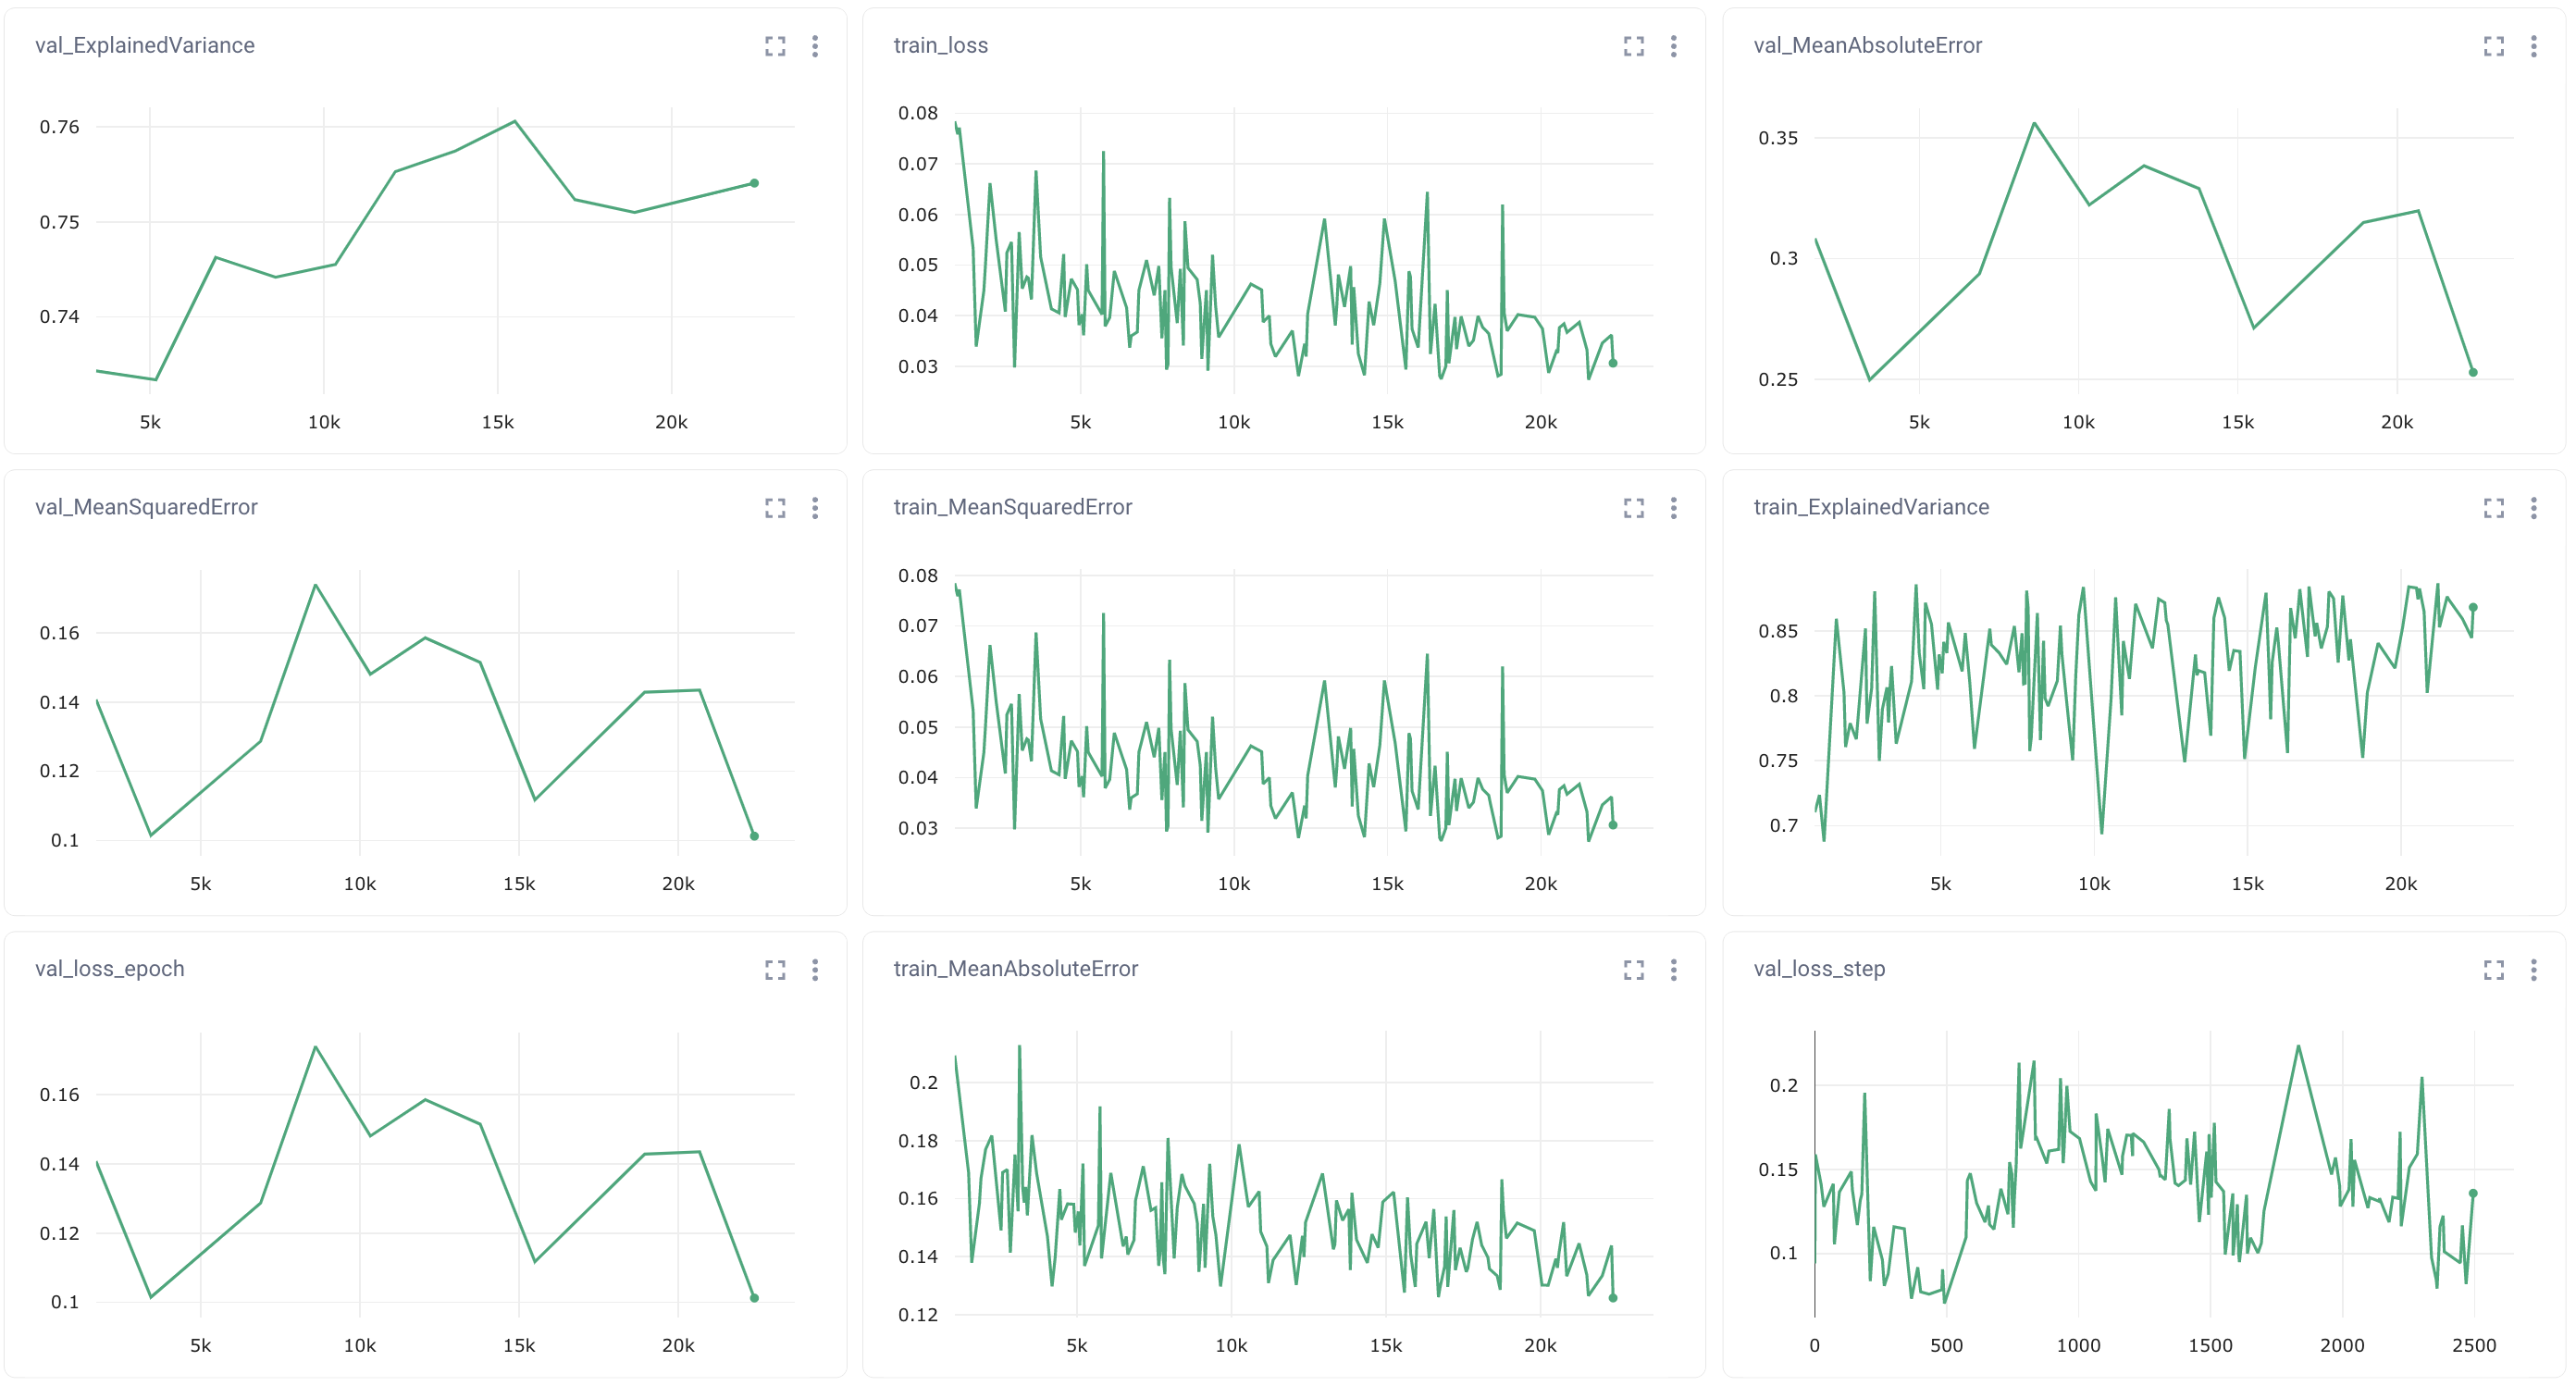

- Рассмотрим двусторонний GRU
- Он показывает себя чуть получше при снятии метрик, хотя ошибка всё равно скачет

In [49]:
hidden_size = 25

description_encoder = GRUBlockNormMaxPool(
    hidden_size=hidden_size,
    num_layers=2,
    bidirectional=True
)

title_encoder = ParallelConvBlock(
    ConvBlockNorm,
    hidden_size=hidden_size,
    kernel_sizes=[2, 3, 4]
)

In [351]:
trainer.logger.experiment.end()
clear_output()

trainer = BaseTrainer(
    logger=BaseLogger(experiment_name="model_hidden_8_bn_bigru_cnn_pretrained_unfreeze")
)

model = MixSalaryPredictor(
    embedder=glove_embeddings,
    hid_size=hidden_size,
    title_encoder=title_encoder,
    description_encoder=description_encoder,
    cat_encoder=cat_encoder,
    final_encoder=final_encoder
)

trainer.fit(
    model,
    train_dataloader,
    val_dataloader
)

trainer.logger.experiment.end()
clear_output()

final_metrics = trainer.validate(model=model, dataloaders=val_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /workspace/salary-pred/e91e1fbfa0b8465f9961f4a2f3f43969/checkpoints/epoch=14-step=25830.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /workspace/salary-pred/e91e1fbfa0b8465f9961f4a2f3f43969/checkpoints/epoch=14-step=25830.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   val_ExplainedVariance   │    0.7680498957633972     │
│   val_MeanAbsoluteError   │     0.173629492521286     │
│   val_MeanSquaredError    │    0.05635818466544151    │
│      val_loss_epoch       │    0.05635818466544151    │
└───────────────────────────┴───────────────────────────┘

#### Metrics

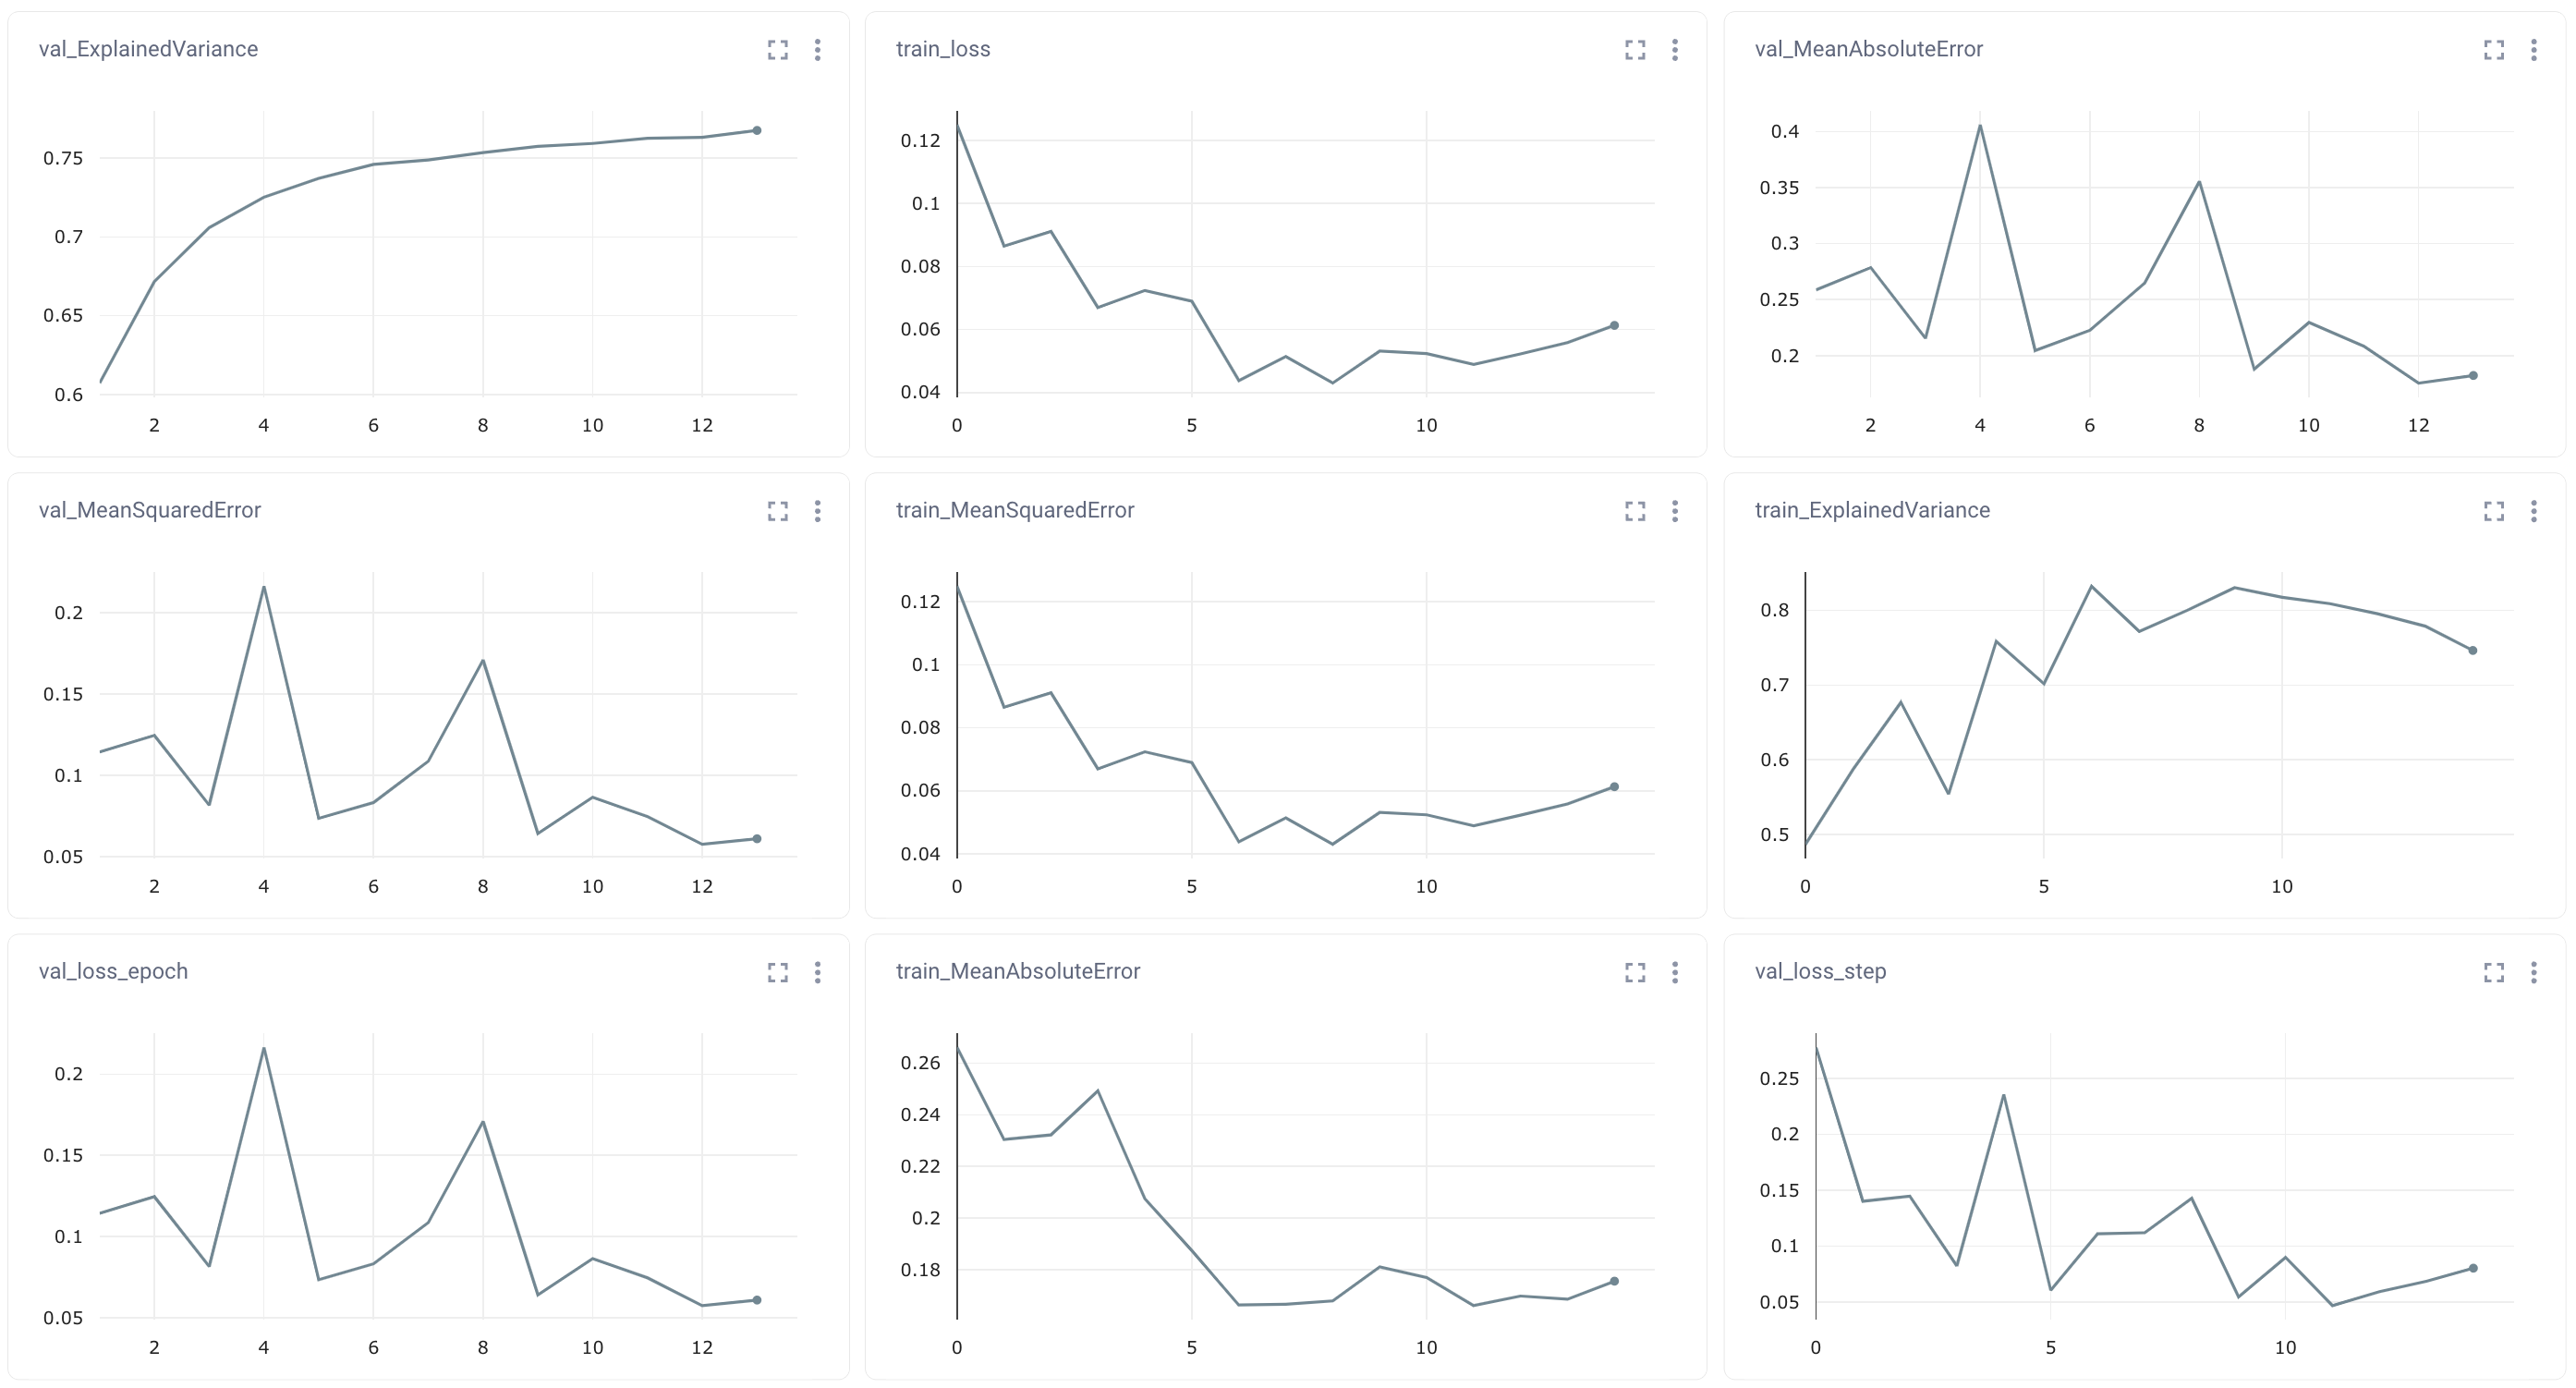

- Наконец, добавили больше слоёв, сделав интересную комбинацию параллельных свёрток и GRU
- Здесь мы получили модели с действительно маленькой ошибкой, но при этом очень даже приличным R^2
- На следующем этапе будем создавать эмбеддинги с помощью этой модели

**5. Вытащите признаки из нейронной сети и используйте их в ансамбле деревьев решений. (2 балла)**

* Вытащите признаки с предпоследнего слоя обученной нейросети и передайте их в ансамбль деревьев решений.
* Сравните результаты работы лучшей нейросети и ансамбля деревьев решений, построенном на признаках из этой нейросети. Сможет ли 
замена последнего слоя на ансамбль деревьев решений улучшить результат?

In [433]:
trainer.callbacks[-1].best_model_path

'/workspace/salary-pred/e91e1fbfa0b8465f9961f4a2f3f43969/checkpoints/epoch=14-step=25830.ckpt'

In [45]:
rf_ckpt = torch.load("/workspace/salary-pred/e91e1fbfa0b8465f9961f4a2f3f43969/checkpoints/epoch=14-step=25830.ckpt")

In [118]:
hidden_size = 25

rf_model = MixSalaryPredictor(
    hid_size=hidden_size,
    title_encoder=title_encoder,
    description_encoder=description_encoder,
    cat_encoder=cat_encoder,
    final_encoder=final_encoder
)

In [61]:
rf_model.load_state_dict(rf_ckpt["state_dict"])

<All keys matched successfully>

In [76]:
rf_model.final_predictor[-1] = nn.Identity()

In [64]:
rf_model.eval()
pass

In [80]:
train_dataloader = DataLoader(
    train_data, 
    shuffle=True, 
    batch_size=512,
    num_workers=8,
    collate_fn=train_collator
)

val_dataloader = DataLoader(
    val_data, 
    shuffle=False, 
    batch_size=512,
    num_workers=8,
    collate_fn=val_collator
)

In [81]:
X_train, y_train = torch.tensor([]), torch.tensor([])

for batch in tqdm(train_dataloader, total=len(train_dataloader)):
    with torch.no_grad():
        embeddings = rf_model(batch)
        batch_target = batch["Log1pSalary"]

        X_train = torch.cat([X_train, embeddings])
        y_train = torch.cat([y_train, batch_target])

  0%|          | 0/431 [00:00<?, ?it/s]

In [77]:
X_val, y_val = torch.tensor([]), torch.tensor([])

for batch in tqdm(val_dataloader, total=len(val_dataloader)):
    with torch.no_grad():
        embeddings = rf_model(batch)
        batch_target = batch["Log1pSalary"]

        X_val = torch.cat([X_val, embeddings])
        y_val = torch.cat([y_val, batch_target])

  0%|          | 0/192 [00:00<?, ?it/s]

In [95]:
rf_reg = RandomForestRegressor()

In [92]:
X_train = X_train.cpu().detach().numpy()
X_val = X_val.cpu().detach().numpy()

y_train = y_train.cpu().detach().numpy()
y_val = y_val.cpu().detach().numpy()

In [96]:
rf_reg.fit(X_train, y_train)

RandomForestRegressor()

In [97]:
preds = rf_reg.predict(X_val)

In [104]:
print("R2:", r2(y_val, preds))
print("Explained Variance:", exp_var(y_val, preds))

print("MSE:", mse(y_val, preds))
print("MAE:", mae(y_val, preds))

R2: 0.7601407430319336
Explained Variance: 0.7602439060410974
MSE: 0.058365481829838084
MAE: 0.17692803321547254


- Видим, что RF модель, обученная на эмбеддингах, полученных из нейронки, работает достаточно сопоставимо с нейронкой по качеству
- Поэтому мы могли бы попробовать интегрировать это прям внутрь, но из коробки это мб и дало бы буст, но он был бы не таким большим

**6. Pooling слои *продвинутые* (3 балла)**

Реализуйте и примените
Softmax-pooling:$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

Attentive pooling$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, где $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$и $NN_{attn}$ полносвязный слой.


- Применияем Softmax и Attention Пулинги

In [43]:
train_dataloader = DataLoader(
    train_data, 
    shuffle=True, 
    batch_size=256,
    num_workers=8,
    collate_fn=train_collator
)

val_dataloader = DataLoader(
    val_data, 
    shuffle=False, 
    batch_size=256,
    num_workers=8,
    collate_fn=val_collator
)

In [120]:
hidden_size = 25

title_encoder = ParallelConvBlock(
    ConvBlockNormSoftmax,
    hidden_size=hidden_size,
    kernel_sizes=[2, 3, 4]
)

description_encoder = GRUBlockNormMaxPool(
    hidden_size=hidden_size,
    num_layers=2,
    bidirectional=True
)

In [121]:
glove_embeddings.weight.requires_grad = True

In [132]:
trainer.logger.experiment.end()
clear_output()

trainer = BaseTrainer(
    logger=BaseLogger(experiment_name="model_hidden_8_bn_bigru_cnn_pretrained_unfreeze_softmax")
)

model = MixSalaryPredictor(
    embedder=glove_embeddings,
    hid_size=hidden_size,
    title_encoder=title_encoder,
    description_encoder=description_encoder,
    cat_encoder=cat_encoder,
    final_encoder=final_encoder
)

trainer.fit(
    model,
    train_dataloader,
    val_dataloader
)

trainer.logger.experiment.end()
clear_output()

final_metrics = trainer.validate(model=model, dataloaders=val_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /workspace/salary-pred/89ecd7c66b8c4f1cb5d790cbe8cbbf2e/checkpoints/epoch=14-step=12915.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /workspace/salary-pred/89ecd7c66b8c4f1cb5d790cbe8cbbf2e/checkpoints/epoch=14-step=12915.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   val_ExplainedVariance   │    0.7904585599899292     │
│   val_MeanAbsoluteError   │    0.16084587574005127    │
│   val_MeanSquaredError    │    0.05102122575044632    │
│      val_loss_epoch       │    0.05102122575044632    │
└───────────────────────────┴───────────────────────────┘

#### Metrics

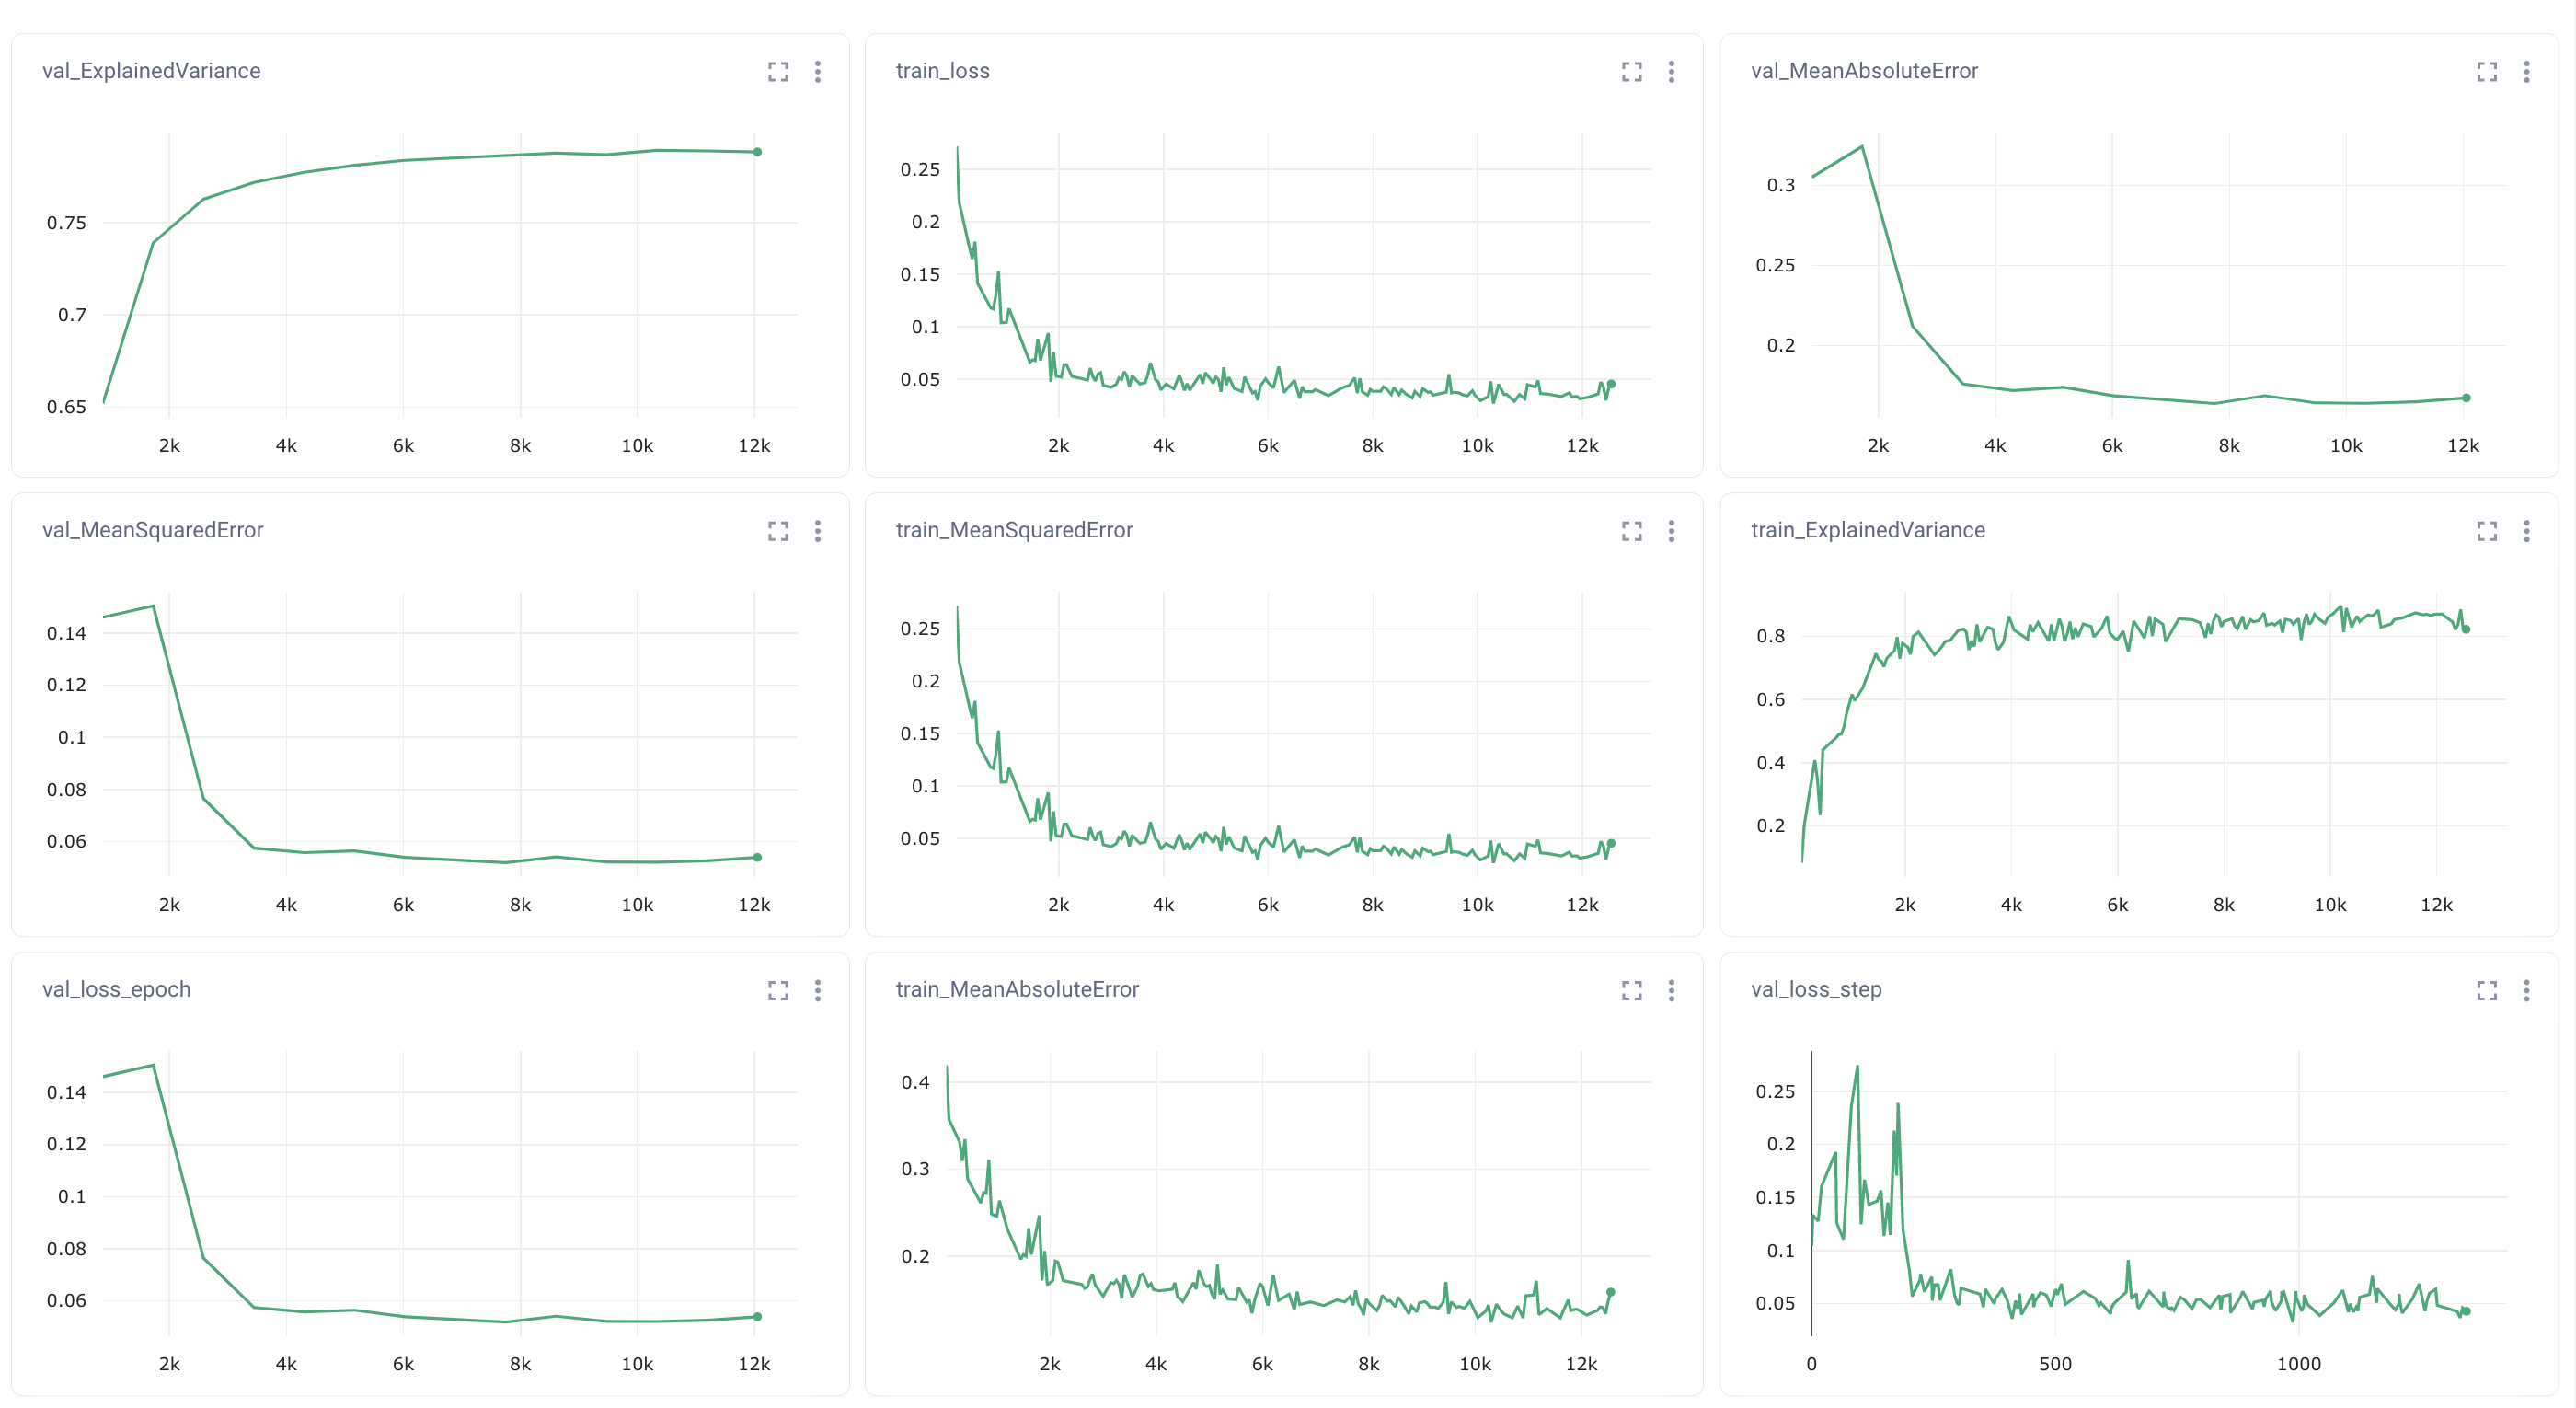

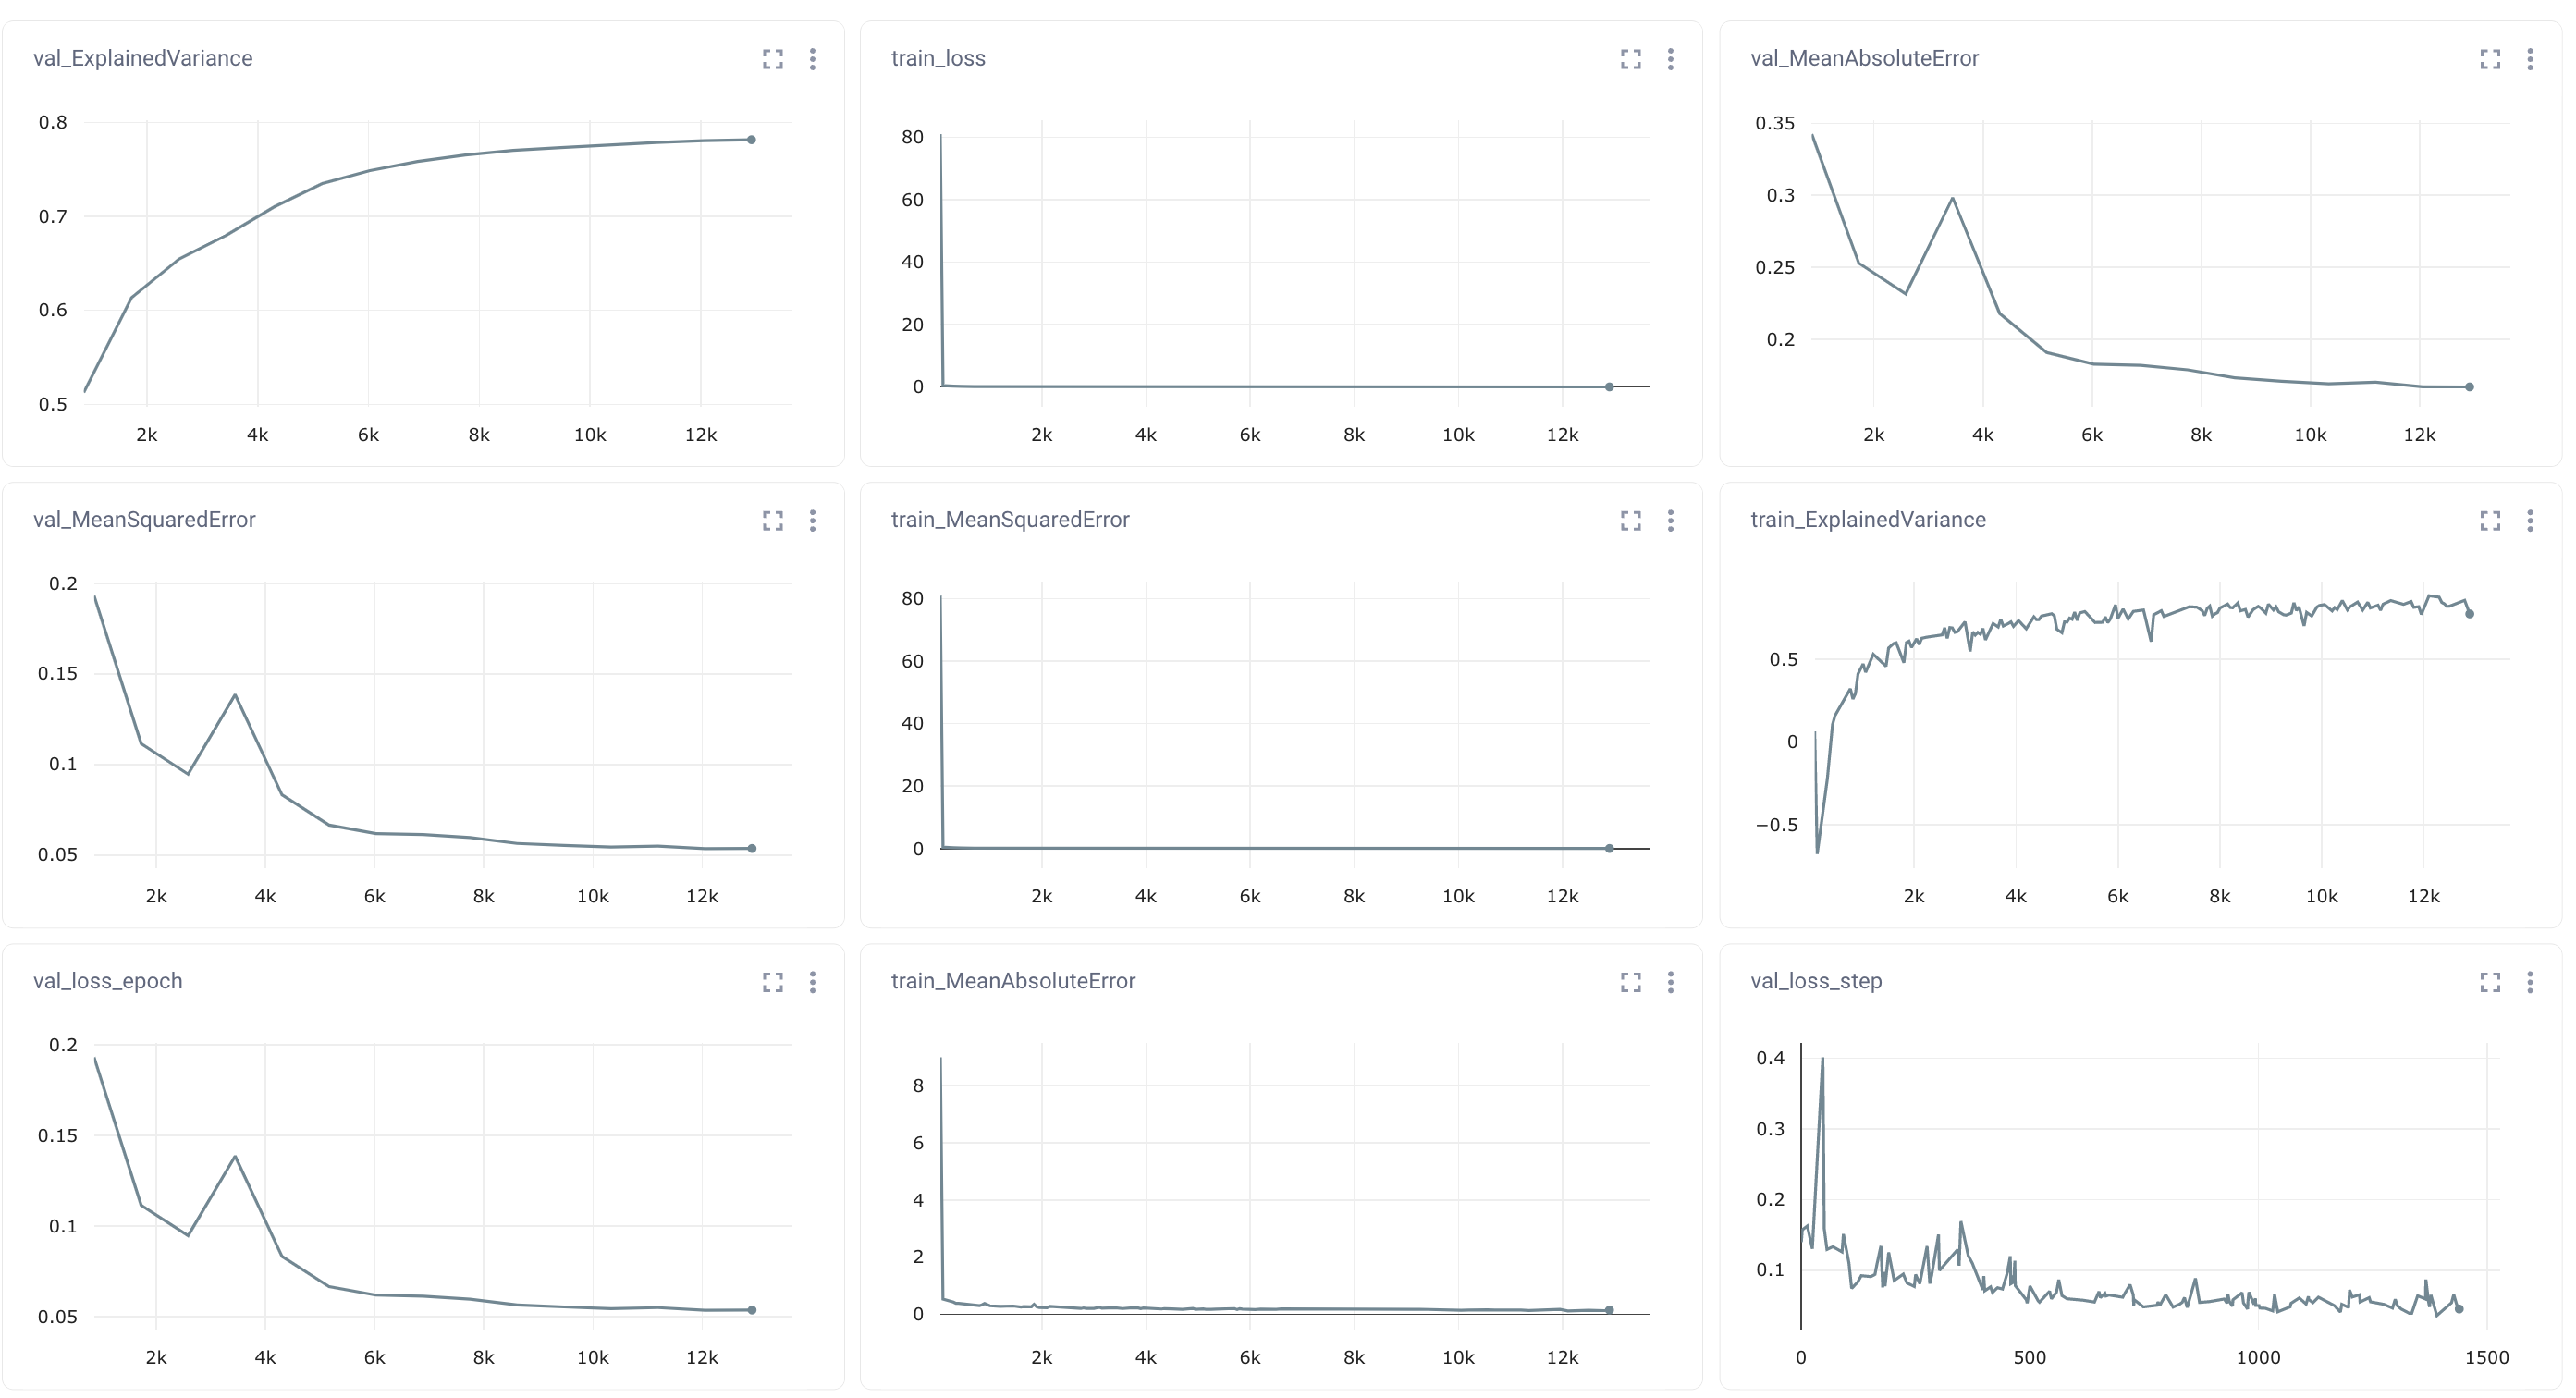

In [268]:
title_encoder = ParallelConvBlock(
    ConvBlockNormAttention,
    hidden_size=hidden_size,
    kernel_sizes=[2, 3, 4]
)

In [271]:
trainer.logger.experiment.end()
clear_output()

trainer = BaseTrainer(
    logger=BaseLogger(experiment_name="model_hidden_8_bn_bigru_cnn_pretrained_unfreeze_attention")
)

model = MixSalaryPredictor(
    embedder=glove_embeddings,
    hid_size=hidden_size,
    title_encoder=title_encoder,
    description_encoder=description_encoder,
    cat_encoder=cat_encoder,
    final_encoder=final_encoder
)

trainer.fit(
    model,
    train_dataloader,
    val_dataloader
)

trainer.logger.experiment.end()
clear_output()

final_metrics = trainer.validate(model=model, dataloaders=val_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /workspace/salary-pred/a69128cd36624c649abbaa756f55bc24/checkpoints/epoch=14-step=12915.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /workspace/salary-pred/a69128cd36624c649abbaa756f55bc24/checkpoints/epoch=14-step=12915.ckpt


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   val_ExplainedVariance   │    0.7724976539611816     │
│   val_MeanAbsoluteError   │    0.17060703039169312    │
│   val_MeanSquaredError    │    0.05631551891565323    │
│      val_loss_epoch       │    0.05631551891565323    │
└───────────────────────────┴───────────────────────────┘

#### Metrics

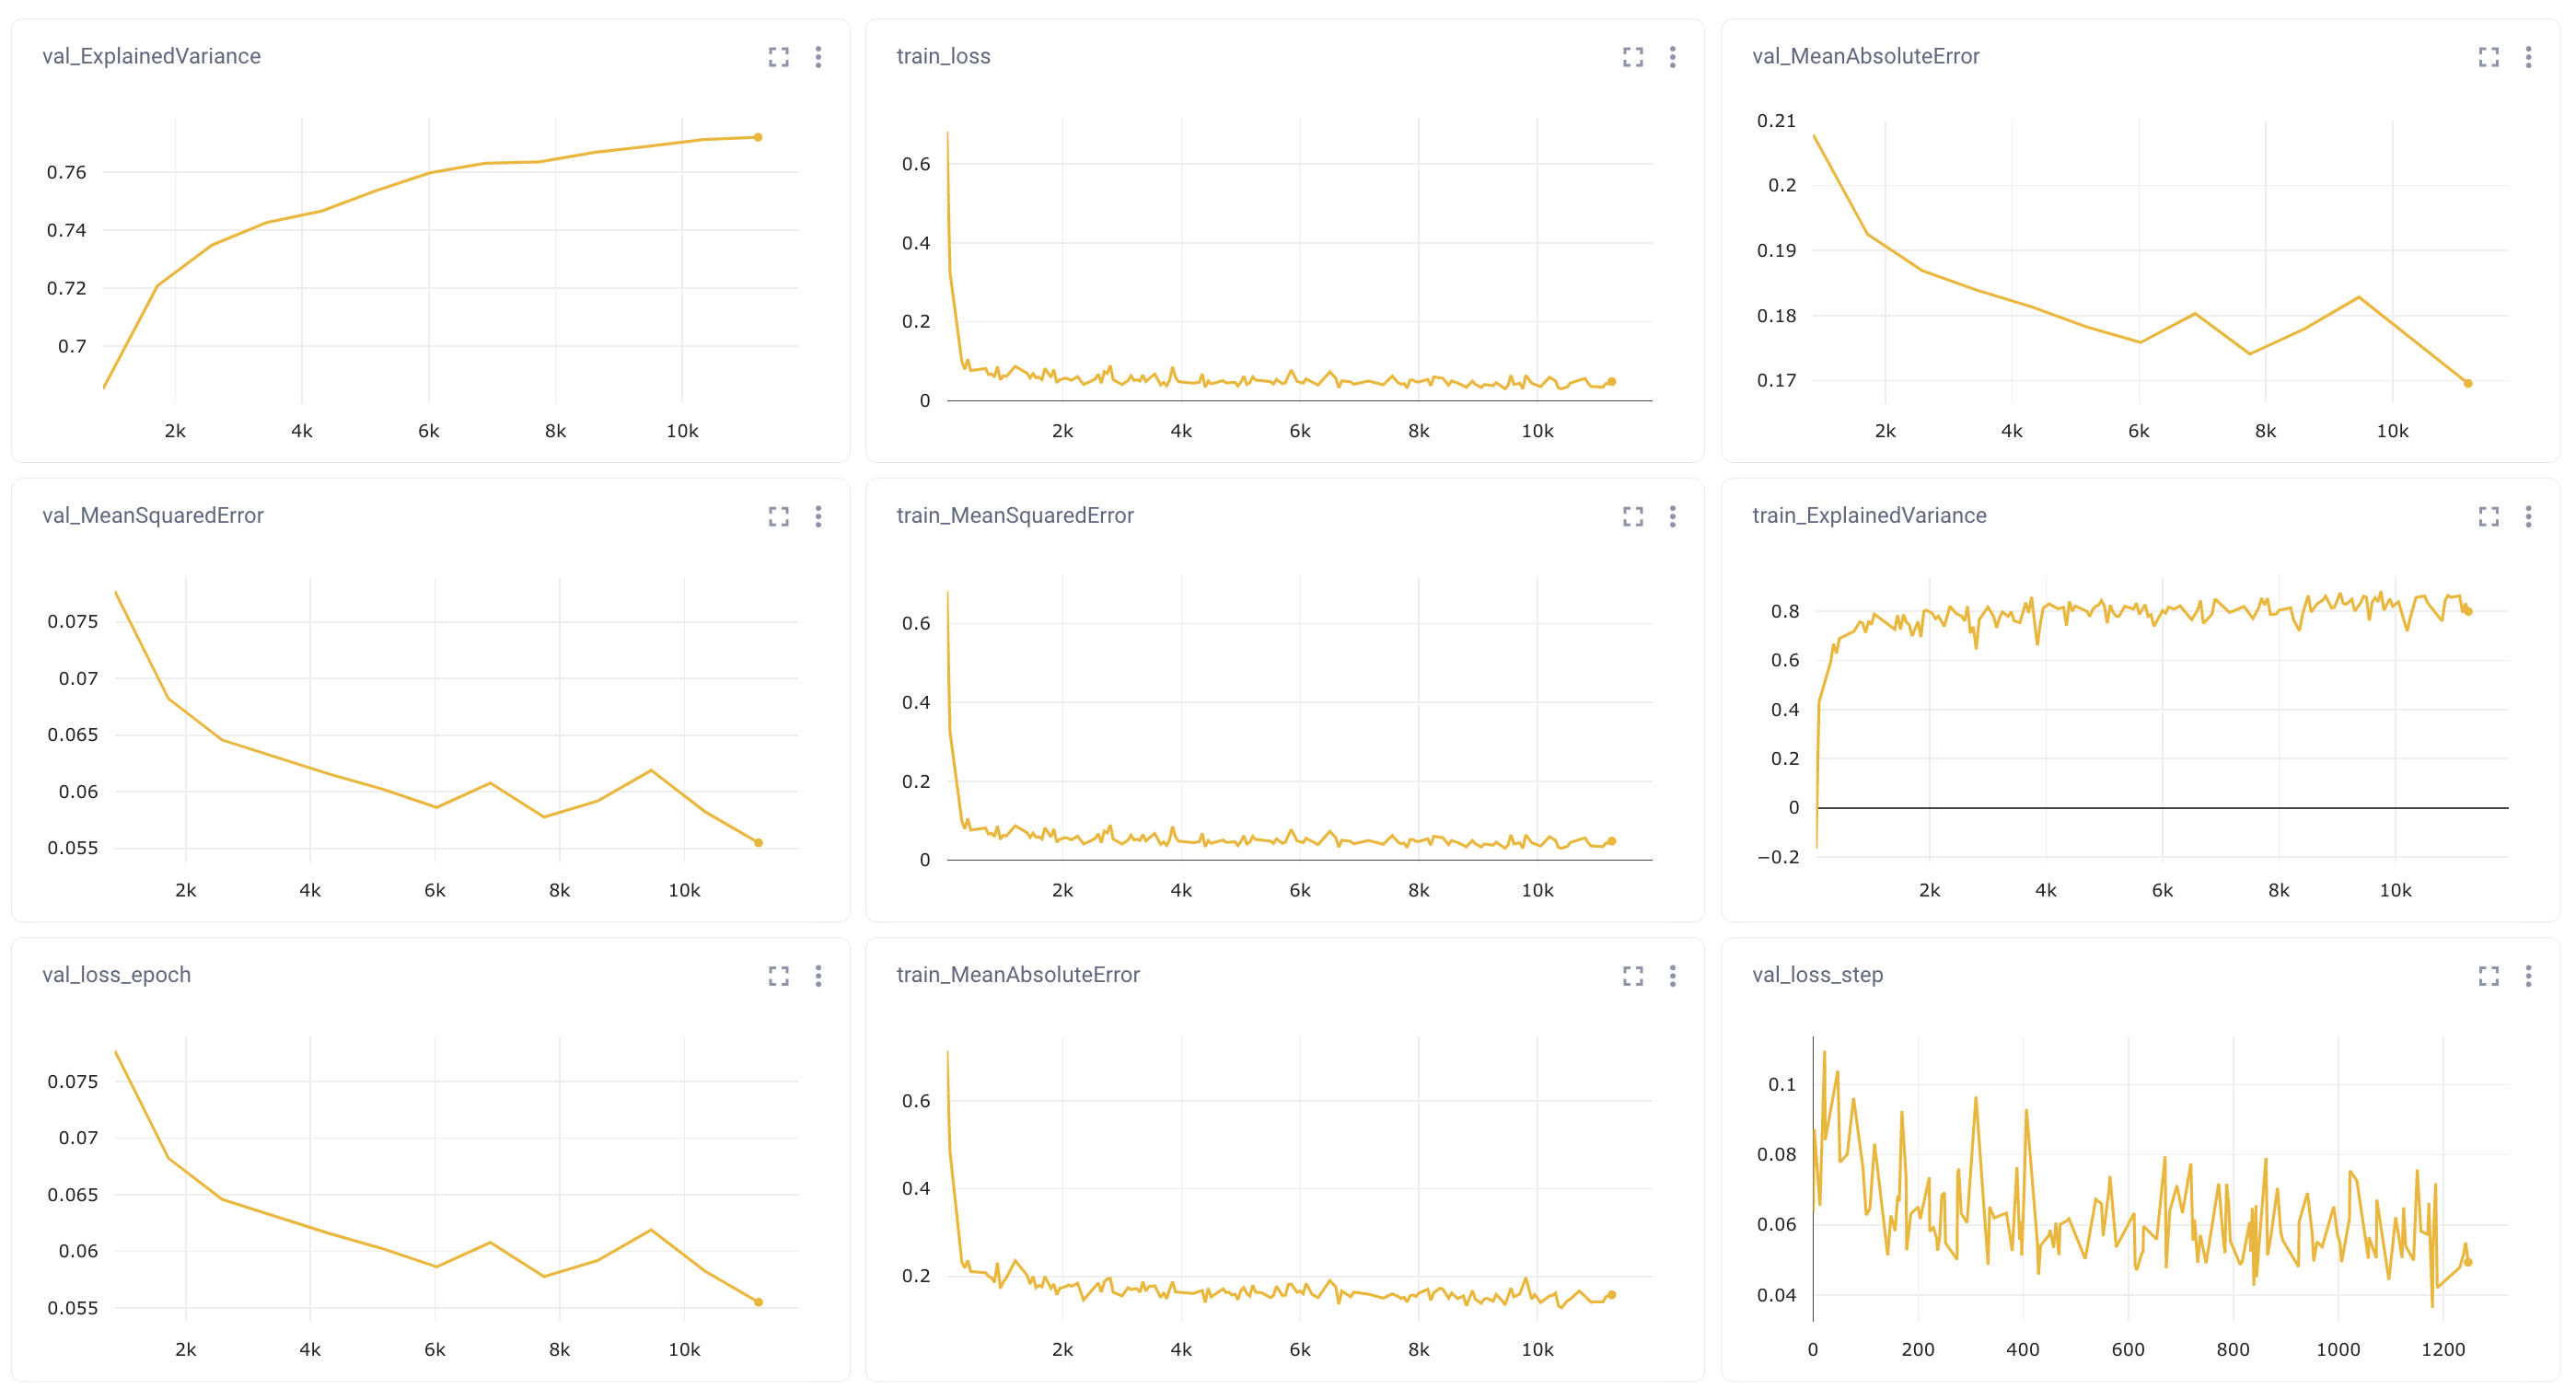

- В целом, Softmax Pooling оказался немного лучше
- Но это легко может быть просто следствией того, что нам нужно было обучать модели с Attention чуть дольше (им нужно много данных)